Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = $3\cdot 10^{-2}$
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
from keras.datasets import cifar10
(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
print("Input shape:",X_train.shape)

Input shape: (50000, 32, 32, 3)


In [4]:
Xstd_train = X_train.astype(DTYPE_OP)/255
Xstd_test = X_test.astype(DTYPE_OP)/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

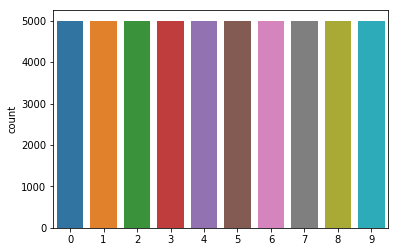

In [9]:
sns.countplot(Z_train)
plt.show()

### Load annotations

In [5]:
scenario = 1
path = "."
state_sce = path+"/synthetic/CIFAR/state_CIFAR_s"+str(scenario)+".pickle"
#state_sce = None #random state

In [6]:
from code.generate_data import SinteticData

GenerateData = SinteticData(state=state_sce)

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario ==5 or scenario==7:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_normal.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_normal.csv')

elif scenario == 2 or scenario == 6: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_badMV.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_badMV.csv')
real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10
elif scenario == 4 or scenario == 6 or scenario ==7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 10000
    T_data = 20
    
print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3 or scenario==7: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones con este valor

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix_R = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

#print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))
print("Accuracy of MV on train: ",np.mean(GenerateData.yo_label == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.73942
Shape (data,annotators):  (50000, 100)
Classes:  10


In [47]:
#generate conf matrix...
confe_matrix_R_ob = np.zeros((T,K,K),dtype=DTYPE_OP)
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R_ob[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R_ob[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R_ob[t,:,:][~mask_nan],axis=0)
    for value in np.arange(K)[mask_nan]:
        confe_matrix_R_ob[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix_R_ob[t,:,:] = confe_matrix_R_ob[t,:,:]/confe_matrix_R_ob[t,:,:].sum(axis=-1,keepdims=True) #normalize

In [30]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.1 , 0.25])

In [7]:
#save it
import pickle
new_state = GenerateData.init_state
with open('state_CIFAR_s'+str(scenario)+'.pickle', 'wb') as handle:
    pickle.dump(new_state, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
new_state = GenerateData.init_state
with open('state_CIFAR_Tchange.pickle', 'wb') as handle:
    pickle.dump(new_state, handle, protocol=pickle.HIGHEST_PROTOCOL) #para cifar habria que cambiar prob de grupos..

#### Delta Convergence criteria

In [19]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [10]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_CNN(Xstd_train.shape[1:],Z_train_onehot.shape[1])
model_UB.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.rmsprop(1e-4))
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
clone_UB = Clonable_Model(model_UB)
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 16


In [11]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [12]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 3000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 3.152921 sec
Representation for DS in 2.357463 sec
Estimation MV in 0.004056 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -745860.1372498269
2 	 -730676.8239632309 	0.1733	0.319473	0.020357
3 	 -728826.4378521828 	0.0456	0.137187	0.002532
4 	 -728503.6243167548 	0.0264	0.077845	0.000443
5 	 -728406.7156455272 	0.0172	0.053441	0.000133
6 	 -728368.0160252679 	0.0116	0.039582	0.000053
7 	 -728350.2788096789 	0.0084	0.029115	0.000024
Class marginals
[0.1  0.1  0.09 0.09 0.1  0.11 0.1  0.1  0.1  0.1 ]
Estimation for DS in 250.431290 sec


In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
if y_obs.shape[1] <= 3000:
    print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.85384


In [13]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 3


In [16]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 10
 9888/10000 [============================>.] - ETA: 0s

In [40]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 5
 9952/10000 [============================>.] - ETA: 0s

### Raykar Model (joint predict model)

In [9]:
from code.baseline import RaykarMC
#get raykar represenstation
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-459f1ec24e27>", line 4, in <module>
    y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
  File "/home/fmena/Desktop/Dataset_Tesis/MixtureofGroups/code/representation.py", line 125, in set_representation
    return categorical_representation(obs)
  File "/home/fmena/Desktop/Dataset_Tesis/MixtureofGroups/code/representation.py", line 11, in categorical_representation
    y_obs_categorical[i,t,obs[i,t]] +=1
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterru

KeyboardInterrupt: 

In [42]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

logL_hists,i_r = raykarMC.multiples_run(15,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (2000, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done,  E step: done //  (in 23.26 sec)	logL: -740141.875	
Iter 2/50 
M step: done,  E step: done //  (in 18.96 sec)	logL: -707188.250	Tol1: 0.04452	Tol2: 0.22569	
Iter 3/50 
M step: done,  E step: done //  (in 18.08 sec)	logL: -694545.062	Tol1: 0.01788	Tol2: 0.10571	
Iter 4/50 
M step: done,  E step: done //  (in 18.74 sec)	logL: -689710.688	Tol1: 0.00696	Tol2: 0.05779	
Iter 5/50 
M step: done,  E step: done //  (in 20.41 sec)	logL: -688077.688	Tol1: 0.00237	Tol2: 0.03760	
Iter 6/50 
M step: done,  E step: done //  (in 18.38 sec)	logL: -688469.812	Tol1: 0.00057	Tol2: 0.02989	
Finished training
Initializing new EM...
Betas shape:  (2000, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done,  E step: done //  (in 22.08 sec)	logL: -741146.125	
Iter 2/50 
M step: done,  E step: done //  (in 18.27 sec)	logL: -706177.125	Tol1: 0.04718	Tol2: 0.22297	
Iter 3/50 
M step: done,  E step

In [43]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test)

 9824/10000 [============================>.] - ETA: 0s

### Our Proposed

In [22]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [23]:
#get our representation 
#r_obs = set_representation(y_obs_categorical,"repeat")
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[ 0  0  0 ...  2  0  0]
 [ 0  2  0 ...  0  2  4]
 [ 0  0  1 ...  0  1  8]
 ...
 [ 0  1  1 ...  1  1  3]
 [ 0 10  0 ...  1  0  1]
 [ 0  4  0 ...  0  1  4]]
shape: (50000, 10)


In [ ]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

In [51]:
M_seted = 4

In [52]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default cnn")
logL_hists,i_r = gMixture_Global.multiples_run(15,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.315320 mins
Lambda by group:  [1. 1. 1. 1.]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 25.46 sec)	logL: -1070360.174	
Iter 2/50
M step: done,  E step: done //  (in 18.88 sec)	logL: -1044816.987	Tol1: 0.02386	Tol2: 0.17464	Tol3: 0.01338	
Iter 3/50
M step: done,  E step: done //  (in 19.38 sec)	logL: -1018834.236	Tol1: 0.02487	Tol2: 0.15818	Tol3: 0.01487	
Iter 4/50
M step: done,  E step: done //  (in 18.75 sec)	logL: -1005096.486	Tol1: 0.01348	Tol2: 0.12779	Tol3: 0.00762	
Iter 5/50
M step: done,  E step: done //  (in 18.69 sec)	logL: -994828.897	Tol1: 0.01022	Tol2: 0.11728	Tol3: 0.01290	
Iter 6/50
M step: done,  E step: done //  (in 18.85 sec)	logL: -986512.078	Tol1: 0.00836	Tol2: 0.08568	Tol3: 0.00812	
Iter 7/50
M step: done,  E step: done //  (in 18.34 sec)	logL: -979911.359	Tol1: 0.00669	Tol2: 0.07474	Tol3: 0.00373	
Iter 8/50
M

M step: done,  E step: done //  (in 17.51 sec)	logL: -949675.461	Tol1: 0.00264	Tol2: 0.04991	Tol3: 0.00286	
Iter 20/50
M step: done,  E step: done //  (in 17.57 sec)	logL: -945410.633	Tol1: 0.00449	Tol2: 0.04641	Tol3: 0.00511	
Iter 21/50
M step: done,  E step: done //  (in 17.51 sec)	logL: -947395.418	Tol1: 0.00210	Tol2: 0.05687	Tol3: 0.00517	
Iter 22/50
M step: done,  E step: done //  (in 17.64 sec)	logL: -948824.866	Tol1: 0.00151	Tol2: 0.04780	Tol3: 0.00556	
Iter 23/50
M step: done,  E step: done //  (in 17.52 sec)	logL: -944028.052	Tol1: 0.00506	Tol2: 0.06350	Tol3: 0.00409	
Iter 24/50
M step: done,  E step: done //  (in 17.64 sec)	logL: -943543.364	Tol1: 0.00051	Tol2: 0.03493	Tol3: 0.00108	
Iter 25/50
M step: done,  E step: done //  (in 17.50 sec)	logL: -943470.705	Tol1: 0.00008	Tol2: 0.04454	Tol3: 0.00224	
Iter 26/50
M step: done,  E step: done //  (in 17.69 sec)	logL: -940421.842	Tol1: 0.00323	Tol2: 0.03205	Tol3: 0.00163	
Iter 27/50
M step: done,  E step: done //  (in 17.51 sec)	l

M step: done,  E step: done //  (in 23.24 sec)	logL: -1060687.977	
Iter 2/50
M step: done,  E step: done //  (in 17.80 sec)	logL: -1036660.604	Tol1: 0.02265	Tol2: 0.19598	Tol3: 0.02128	
Iter 3/50
M step: done,  E step: done //  (in 17.69 sec)	logL: -1015811.763	Tol1: 0.02011	Tol2: 0.15327	Tol3: 0.01289	
Iter 4/50
M step: done,  E step: done //  (in 17.82 sec)	logL: -1010089.166	Tol1: 0.00563	Tol2: 0.11519	Tol3: 0.00840	
Iter 5/50
M step: done,  E step: done //  (in 17.73 sec)	logL: -1000336.855	Tol1: 0.00965	Tol2: 0.09723	Tol3: 0.00645	
Iter 6/50
M step: done,  E step: done //  (in 17.77 sec)	logL: -989092.571	Tol1: 0.01124	Tol2: 0.09637	Tol3: 0.01211	
Iter 7/50
M step: done,  E step: done //  (in 17.76 sec)	logL: -979994.851	Tol1: 0.00920	Tol2: 0.07754	Tol3: 0.00198	
Iter 8/50
M step: done,  E step: done //  (in 17.77 sec)	logL: -973176.810	Tol1: 0.00696	Tol2: 0.10509	Tol3: 0.00324	
Iter 9/50
M step: done,  E step: done //  (in 17.72 sec)	logL: -967926.196	Tol1: 0.00540	Tol2: 0.06218	

M step: done,  E step: done //  (in 17.66 sec)	logL: -1019077.356	Tol1: 0.01694	Tol2: 0.17022	Tol3: 0.01753	
Iter 4/50
M step: done,  E step: done //  (in 17.78 sec)	logL: -1004873.824	Tol1: 0.01394	Tol2: 0.14608	Tol3: 0.01627	
Iter 5/50
M step: done,  E step: done //  (in 17.74 sec)	logL: -994380.135	Tol1: 0.01044	Tol2: 0.09539	Tol3: 0.00554	
Iter 6/50
M step: done,  E step: done //  (in 17.89 sec)	logL: -989787.007	Tol1: 0.00462	Tol2: 0.06667	Tol3: 0.00264	
Iter 7/50
M step: done,  E step: done //  (in 17.68 sec)	logL: -982086.179	Tol1: 0.00778	Tol2: 0.09378	Tol3: 0.00629	
Iter 8/50
M step: done,  E step: done //  (in 17.79 sec)	logL: -977889.620	Tol1: 0.00427	Tol2: 0.09333	Tol3: 0.00607	
Iter 9/50
M step: done,  E step: done //  (in 17.66 sec)	logL: -974649.672	Tol1: 0.00331	Tol2: 0.05037	Tol3: 0.01024	
Iter 10/50
M step: done,  E step: done //  (in 17.78 sec)	logL: -971244.023	Tol1: 0.00349	Tol2: 0.07219	Tol3: 0.00689	
Iter 11/50
M step: done,  E step: done //  (in 17.59 sec)	logL:

M step: done,  E step: done //  (in 17.90 sec)	logL: -957099.524	Tol1: 0.00253	Tol2: 0.06161	Tol3: 0.00581	
Iter 14/50
M step: done,  E step: done //  (in 18.07 sec)	logL: -958199.925	Tol1: 0.00115	Tol2: 0.04654	Tol3: 0.00390	
Iter 15/50
M step: done,  E step: done //  (in 17.93 sec)	logL: -958408.048	Tol1: 0.00022	Tol2: 0.06919	Tol3: 0.00288	
Iter 16/50
M step: done,  E step: done //  (in 18.02 sec)	logL: -952197.829	Tol1: 0.00648	Tol2: 0.05853	Tol3: 0.00224	
Iter 17/50
M step: done,  E step: done //  (in 17.88 sec)	logL: -952272.659	Tol1: 0.00008	Tol2: 0.04504	Tol3: 0.00280	
Iter 18/50
M step: done,  E step: done //  (in 18.09 sec)	logL: -948240.723	Tol1: 0.00423	Tol2: 0.06234	Tol3: 0.00604	
Iter 19/50
M step: done,  E step: done //  (in 17.86 sec)	logL: -947692.873	Tol1: 0.00058	Tol2: 0.04437	Tol3: 0.00569	
Iter 20/50
M step: done,  E step: done //  (in 18.08 sec)	logL: -943877.319	Tol1: 0.00403	Tol2: 0.04180	Tol3: 0.00406	
Iter 21/50
M step: done,  E step: done //  (in 18.03 sec)	l

M step: done,  E step: done //  (in 17.73 sec)	logL: -942019.280	Tol1: 0.00203	Tol2: 0.03879	Tol3: 0.00387	
Iter 25/50
M step: done,  E step: done //  (in 17.81 sec)	logL: -941460.876	Tol1: 0.00059	Tol2: 0.02484	Tol3: 0.00148	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.303534 mins
Lambda by group:  [1. 1. 1. 1.]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 23.12 sec)	logL: -1065268.989	
Iter 2/50
M step: done,  E step: done //  (in 17.78 sec)	logL: -1041220.077	Tol1: 0.02258	Tol2: 0.21627	Tol3: 0.01350	
Iter 3/50
M step: done,  E step: done //  (in 17.72 sec)	logL: -1023694.982	Tol1: 0.01683	Tol2: 0.15879	Tol3: 0.00694	
Iter 4/50
M step: done,  E step: done //  (in 17.79 sec)	logL: -1004058.144	Tol1: 0.01918	Tol2: 0.12697	Tol3: 0.00395	
Iter 5/50
M step: done,  E step: done //  (in 17.69 sec)	logL: -995249.657	Tol1: 0.00877	Tol2: 0.09656	Tol3: 0.00641	
I

M step: done,  E step: done //  (in 17.75 sec)	logL: -986838.980	Tol1: 0.01000	Tol2: 0.09700	Tol3: 0.00205	
Iter 6/50
M step: done,  E step: done //  (in 17.76 sec)	logL: -981913.885	Tol1: 0.00499	Tol2: 0.07410	Tol3: 0.00446	
Iter 7/50
M step: done,  E step: done //  (in 17.70 sec)	logL: -978381.478	Tol1: 0.00360	Tol2: 0.06811	Tol3: 0.00618	
Iter 8/50
M step: done,  E step: done //  (in 17.81 sec)	logL: -973618.164	Tol1: 0.00487	Tol2: 0.07630	Tol3: 0.00683	
Iter 9/50
M step: done,  E step: done //  (in 17.73 sec)	logL: -973028.489	Tol1: 0.00061	Tol2: 0.09077	Tol3: 0.00460	
Iter 10/50
M step: done,  E step: done //  (in 17.75 sec)	logL: -972223.606	Tol1: 0.00083	Tol2: 0.07909	Tol3: 0.00982	
Iter 11/50
M step: done,  E step: done //  (in 17.74 sec)	logL: -973110.303	Tol1: 0.00091	Tol2: 0.05694	Tol3: 0.00807	
Iter 12/50
M step: done,  E step: done //  (in 17.80 sec)	logL: -971854.036	Tol1: 0.00129	Tol2: 0.06136	Tol3: 0.00863	
Iter 13/50
M step: done,  E step: done //  (in 17.69 sec)	logL:

In [53]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [33]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T)
print("vector of variable one-hots:\n",Y_ann_train[:2])
print("shape of annotator representation (T,R_t)=", A.shape)

vector of variable one-hots:
 [array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8)
 array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int8)]
shape of annotator representation (T,R_t)= (100, 100)


shape of annotator representation (T, R_t)= (100, 10)


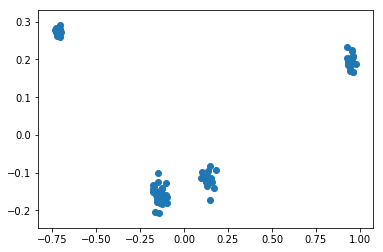

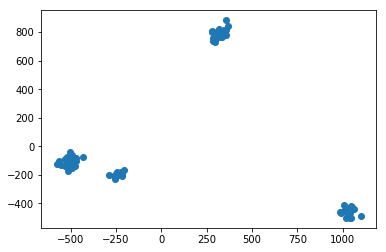

array([[ 543.,  526.,  361.,  414.,  620.,  506.,  616.,  485.,  493.,
         468.],
       [   0.,   30.,  221.,  115., 1124.,  600., 1045.,  562.,   20.,
        1297.],
       [ 380.,  488.,  298.,  624.,  401.,  788.,  561.,  435.,  618.,
         405.],
       [ 351.,  512.,  283.,  645.,  396.,  757.,  630.,  417.,  618.,
         435.],
       [ 373.,  532.,  299.,  610.,  378.,  725.,  563.,  400.,  616.,
         400.],
       [ 262.,  413.,  506.,  415.,  158.,  540., 1582.,  233.,  220.,
         654.],
       [   0.,   28.,  265.,  134., 1135.,  614.,  986.,  555.,   14.,
        1271.],
       [ 556.,  514.,  350.,  389.,  609.,  511.,  630.,  507.,  489.,
         506.],
       [ 538.,  509.,  341.,  388.,  656.,  468.,  670.,  494.,  511.,
         519.],
       [ 391.,  487.,  309.,  659.,  386.,  764.,  607.,  418.,  593.,
         432.],
       [   0.,   22.,  260.,  112., 1121.,  629.,  938.,  543.,   10.,
        1289.],
       [   0.,   33.,  243.,  116., 1146., 

In [34]:
from code.MixtureofGroups import *

conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], K))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(K),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

A_rep = np.zeros((y_obs.shape[1], K))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [35]:
#different M_seted?
M_seted = 4

In [72]:
gMixture_Ind1 = GroupMixtureInd(Xstd_train.shape[1:],Kl=K,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("default cnn")
gMixture_Ind1.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i = gMixture_Ind1.multiples_run(15,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.039811 mins
Lambda by group:  [1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (499303, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 29.79 sec)	logL: -979460.459	
Iter 2/50
M step: done,  E step: done //  (in 21.68 sec)	logL: -932622.003	Tol1: 0.04782	Tol2: 0.26695	
Iter 3/50
M step: done,  E step: done //  (in 21.70 sec)	logL: -905318.545	Tol1: 0.02928	Tol2: 0.22746	
Iter 4/50
M step: done,  E step: done //  (in 21.78 sec)	logL: -890620.732	Tol1: 0.01623	Tol2: 0.17131	
Iter 5/50
M step: done,  E step: done //  (in 22.12 sec)	logL: -887681.916	Tol1: 0.00330	Tol2: 0.14374	
Iter 6/50
M step: done,  E step: done //  (in 21.99 sec)	logL: -878027.793	Tol1: 0.01088	Tol2: 0.11993	
Iter 7/50
M step: done,  E step: done //  (in 21.95 sec)	logL: -868988.789	Tol1: 0.01029	Tol2: 0.09940	
Iter 8/50
M step: done

M step: done,  E step: done //  (in 21.56 sec)	logL: -845635.099	Tol1: 0.00270	Tol2: 0.05170	
Iter 20/50
M step: done,  E step: done //  (in 21.39 sec)	logL: -839828.187	Tol1: 0.00687	Tol2: 0.05505	
Iter 21/50
M step: done,  E step: done //  (in 21.56 sec)	logL: -839192.267	Tol1: 0.00076	Tol2: 0.04977	
Iter 22/50
M step: done,  E step: done //  (in 21.39 sec)	logL: -839178.998	Tol1: 0.00002	Tol2: 0.03443	
Iter 23/50
M step: done,  E step: done //  (in 21.50 sec)	logL: -838542.352	Tol1: 0.00076	Tol2: 0.02843	
Finished training!
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.037899 mins
Lambda by group:  [1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (499303, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 28.35 sec)	logL: -981344.763	
Iter 2/50
M step: done,  E step: done //  (in 22.03 sec)	logL: -934917.784	Tol1: 0.04731	Tol2: 0.26118	
Iter 3/50

M step: done,  E step: done //  (in 21.61 sec)	logL: -858452.062	Tol1: 0.00545	Tol2: 0.05325	
Iter 12/50
M step: done,  E step: done //  (in 21.57 sec)	logL: -854408.280	Tol1: 0.00471	Tol2: 0.05495	
Iter 13/50
M step: done,  E step: done //  (in 21.61 sec)	logL: -855634.786	Tol1: 0.00144	Tol2: 0.04162	
Iter 14/50
M step: done,  E step: done //  (in 21.62 sec)	logL: -855078.740	Tol1: 0.00065	Tol2: 0.05616	
Iter 15/50
M step: done,  E step: done //  (in 21.57 sec)	logL: -855363.471	Tol1: 0.00033	Tol2: 0.04135	
Iter 16/50
M step: done,  E step: done //  (in 21.64 sec)	logL: -849396.866	Tol1: 0.00698	Tol2: 0.06348	
Iter 17/50
M step: done,  E step: done //  (in 21.60 sec)	logL: -846881.523	Tol1: 0.00296	Tol2: 0.04709	
Iter 18/50
M step: done,  E step: done //  (in 21.58 sec)	logL: -844611.942	Tol1: 0.00268	Tol2: 0.04657	
Iter 19/50
M step: done,  E step: done //  (in 21.61 sec)	logL: -842999.537	Tol1: 0.00191	Tol2: 0.04258	
Iter 20/50
M step: done,  E step: done //  (in 21.52 sec)	logL: -8

M step: done,  E step: done //  (in 21.51 sec)	logL: -846232.101	Tol1: 0.01041	Tol2: 0.08471	
Iter 16/50
M step: done,  E step: done //  (in 21.47 sec)	logL: -845807.397	Tol1: 0.00050	Tol2: 0.05272	
Iter 17/50
M step: done,  E step: done //  (in 21.52 sec)	logL: -842223.870	Tol1: 0.00424	Tol2: 0.05350	
Iter 18/50
M step: done,  E step: done //  (in 21.50 sec)	logL: -840422.029	Tol1: 0.00214	Tol2: 0.04113	
Iter 19/50
M step: done,  E step: done //  (in 21.47 sec)	logL: -839541.263	Tol1: 0.00105	Tol2: 0.03768	
Iter 20/50
M step: done,  E step: done //  (in 21.59 sec)	logL: -839677.993	Tol1: 0.00016	Tol2: 0.03416	
Iter 21/50
M step: done,  E step: done //  (in 21.51 sec)	logL: -841737.837	Tol1: 0.00245	Tol2: 0.03727	
Iter 22/50
M step: done,  E step: done //  (in 21.52 sec)	logL: -844837.822	Tol1: 0.00368	Tol2: 0.04680	
Iter 23/50
M step: done,  E step: done //  (in 21.49 sec)	logL: -839200.107	Tol1: 0.00667	Tol2: 0.04586	
Iter 24/50
M step: done,  E step: done //  (in 21.56 sec)	logL: -8

Iter 1/50
M step: done,  E step: done //  (in 28.59 sec)	logL: -987033.474	
Iter 2/50
M step: done,  E step: done //  (in 21.70 sec)	logL: -941347.792	Tol1: 0.04629	Tol2: 0.26122	
Iter 3/50
M step: done,  E step: done //  (in 21.71 sec)	logL: -916334.231	Tol1: 0.02657	Tol2: 0.23299	
Iter 4/50
M step: done,  E step: done //  (in 21.69 sec)	logL: -894932.106	Tol1: 0.02336	Tol2: 0.18039	
Iter 5/50
M step: done,  E step: done //  (in 21.61 sec)	logL: -889822.277	Tol1: 0.00571	Tol2: 0.15976	
Iter 6/50
M step: done,  E step: done //  (in 21.71 sec)	logL: -873253.865	Tol1: 0.01862	Tol2: 0.13210	
Iter 7/50
M step: done,  E step: done //  (in 21.57 sec)	logL: -865503.811	Tol1: 0.00887	Tol2: 0.08604	
Iter 8/50
M step: done,  E step: done //  (in 21.63 sec)	logL: -864074.354	Tol1: 0.00165	Tol2: 0.07162	
Iter 9/50
M step: done,  E step: done //  (in 21.57 sec)	logL: -859866.543	Tol1: 0.00487	Tol2: 0.06804	
Iter 10/50
M step: done,  E step: done //  (in 21.71 sec)	logL: -856617.995	Tol1: 0.00378	To

M step: done,  E step: done //  (in 21.47 sec)	logL: -840025.866	Tol1: 0.00348	Tol2: 0.05220	
Iter 24/50
M step: done,  E step: done //  (in 21.45 sec)	logL: -838094.582	Tol1: 0.00230	Tol2: 0.04995	
Iter 25/50
M step: done,  E step: done //  (in 21.55 sec)	logL: -835121.480	Tol1: 0.00355	Tol2: 0.03518	
Iter 26/50
M step: done,  E step: done //  (in 21.56 sec)	logL: -834915.484	Tol1: 0.00025	Tol2: 0.03635	
Iter 27/50
M step: done,  E step: done //  (in 21.46 sec)	logL: -834828.468	Tol1: 0.00010	Tol2: 0.03418	
Iter 28/50
M step: done,  E step: done //  (in 21.52 sec)	logL: -833379.629	Tol1: 0.00174	Tol2: 0.02817	
Finished training!
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.037591 mins
Lambda by group:  [1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (499303, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 28.64 sec)	logL: -987727.515	
Iter 2/5

In [73]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [74]:
#A rep normalize y bn true
A_rep = A_rep/A_rep.sum(axis=-1,keepdims=True)

In [75]:
gMixture_Ind3 = GroupMixtureInd(Xstd_train.shape[1:],Kl=K,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("default cnn")
gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], K*M_seted, 1, BatchN=True, embed=False)
logL_hists,i_r = gMixture_Ind3.multiples_run(15,Xstd_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                      pre_init_z=3,pre_init_g=0, max_iter=EPOCHS_BASE,tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000388 mins
Lambda by group:  [1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (499303, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 31.41 sec)	logL: -973704.550	
Iter 2/50
M step: done,  E step: done //  (in 22.37 sec)	logL: -922175.418	Tol1: 0.05292	Tol2: 0.24605	
Iter 3/50
M step: done,  E step: done //  (in 22.51 sec)	logL: -897123.513	Tol1: 0.02717	Tol2: 0.22613	
Iter 4/50
M step: done,  E step: done //  (in 22.42 sec)	logL: -885395.080	Tol1: 0.01307	Tol2: 0.16366	
Iter 5/50
M step: done,  E step: done //  (in 22.46 sec)	logL: -876780.752	Tol1: 0.00973	Tol2: 0.12122	
Iter 6/50
M step: done,  E step: done //  (in 22.45 sec)	logL: -868643.152	Tol1: 0.00928	Tol2: 0.09457	
Iter 7/50
M step: done,  E step: done //  (in 22.40 sec)	logL: -866729.103	Tol1: 0.00220	Tol2: 0.09028	
Iter 8/50
M step: done,  E 

M step: done,  E step: done //  (in 22.25 sec)	logL: -841985.966	Tol1: 0.00785	Tol2: 0.09290	
Iter 18/50
M step: done,  E step: done //  (in 22.31 sec)	logL: -839644.905	Tol1: 0.00278	Tol2: 0.04318	
Iter 19/50
M step: done,  E step: done //  (in 22.44 sec)	logL: -840918.557	Tol1: 0.00152	Tol2: 0.03359	
Iter 20/50
M step: done,  E step: done //  (in 22.26 sec)	logL: -840142.157	Tol1: 0.00092	Tol2: 0.05399	
Iter 21/50
M step: done,  E step: done //  (in 22.33 sec)	logL: -838850.622	Tol1: 0.00154	Tol2: 0.03991	
Iter 22/50
M step: done,  E step: done //  (in 22.27 sec)	logL: -839655.490	Tol1: 0.00096	Tol2: 0.05192	
Iter 23/50
M step: done,  E step: done //  (in 22.26 sec)	logL: -836259.369	Tol1: 0.00404	Tol2: 0.04143	
Iter 24/50
M step: done,  E step: done //  (in 22.26 sec)	logL: -838723.146	Tol1: 0.00295	Tol2: 0.03430	
Iter 25/50
M step: done,  E step: done //  (in 22.27 sec)	logL: -836142.948	Tol1: 0.00308	Tol2: 0.05321	
Iter 26/50
M step: done,  E step: done //  (in 22.23 sec)	logL: -8

M step: done,  E step: done //  (in 22.23 sec)	logL: -897008.994	Tol1: 0.02989	Tol2: 0.22483	
Iter 4/50
M step: done,  E step: done //  (in 22.27 sec)	logL: -891588.313	Tol1: 0.00604	Tol2: 0.17092	
Iter 5/50
M step: done,  E step: done //  (in 22.30 sec)	logL: -879196.232	Tol1: 0.01390	Tol2: 0.12963	
Iter 6/50
M step: done,  E step: done //  (in 22.30 sec)	logL: -867811.553	Tol1: 0.01295	Tol2: 0.08978	
Iter 7/50
M step: done,  E step: done //  (in 22.25 sec)	logL: -865792.094	Tol1: 0.00233	Tol2: 0.09188	
Iter 8/50
M step: done,  E step: done //  (in 22.30 sec)	logL: -869224.971	Tol1: 0.00397	Tol2: 0.08369	
Iter 9/50
M step: done,  E step: done //  (in 22.20 sec)	logL: -859698.170	Tol1: 0.01096	Tol2: 0.07621	
Iter 10/50
M step: done,  E step: done //  (in 22.24 sec)	logL: -858932.647	Tol1: 0.00089	Tol2: 0.06715	
Iter 11/50
M step: done,  E step: done //  (in 22.21 sec)	logL: -856147.661	Tol1: 0.00324	Tol2: 0.07415	
Iter 12/50
M step: done,  E step: done //  (in 22.22 sec)	logL: -853884.

M step: done,  E step: done //  (in 22.03 sec)	logL: -899224.213	Tol1: 0.03003	Tol2: 0.22578	
Iter 4/50
M step: done,  E step: done //  (in 22.06 sec)	logL: -883309.039	Tol1: 0.01770	Tol2: 0.17936	
Iter 5/50
M step: done,  E step: done //  (in 22.08 sec)	logL: -876020.689	Tol1: 0.00825	Tol2: 0.11814	
Iter 6/50
M step: done,  E step: done //  (in 22.15 sec)	logL: -870849.094	Tol1: 0.00590	Tol2: 0.08905	
Iter 7/50
M step: done,  E step: done //  (in 22.07 sec)	logL: -869922.375	Tol1: 0.00106	Tol2: 0.09307	
Iter 8/50
M step: done,  E step: done //  (in 22.09 sec)	logL: -866463.385	Tol1: 0.00398	Tol2: 0.07564	
Iter 9/50
M step: done,  E step: done //  (in 22.14 sec)	logL: -860678.645	Tol1: 0.00668	Tol2: 0.07261	
Iter 10/50
M step: done,  E step: done //  (in 22.12 sec)	logL: -860454.872	Tol1: 0.00026	Tol2: 0.06872	
Iter 11/50
M step: done,  E step: done //  (in 22.03 sec)	logL: -858360.695	Tol1: 0.00243	Tol2: 0.07805	
Iter 12/50
M step: done,  E step: done //  (in 22.06 sec)	logL: -854461.

M step: done,  E step: done //  (in 22.24 sec)	logL: -856742.266	Tol1: 0.00563	Tol2: 0.07220	
Iter 10/50
M step: done,  E step: done //  (in 22.27 sec)	logL: -858852.548	Tol1: 0.00246	Tol2: 0.07800	
Iter 11/50
M step: done,  E step: done //  (in 22.22 sec)	logL: -854649.475	Tol1: 0.00489	Tol2: 0.08883	
Iter 12/50
M step: done,  E step: done //  (in 22.21 sec)	logL: -852550.755	Tol1: 0.00246	Tol2: 0.09383	
Iter 13/50
M step: done,  E step: done //  (in 22.31 sec)	logL: -849077.035	Tol1: 0.00407	Tol2: 0.06829	
Iter 14/50
M step: done,  E step: done //  (in 22.23 sec)	logL: -848519.393	Tol1: 0.00066	Tol2: 0.05443	
Iter 15/50
M step: done,  E step: done //  (in 22.20 sec)	logL: -845857.748	Tol1: 0.00314	Tol2: 0.04965	
Iter 16/50
M step: done,  E step: done //  (in 22.24 sec)	logL: -842395.056	Tol1: 0.00409	Tol2: 0.04187	
Iter 17/50
M step: done,  E step: done //  (in 22.35 sec)	logL: -840260.412	Tol1: 0.00253	Tol2: 0.04204	
Iter 18/50
M step: done,  E step: done //  (in 22.29 sec)	logL: -8

M step: done,  E step: done //  (in 22.02 sec)	logL: -838636.265	Tol1: 0.00352	Tol2: 0.03508	
Iter 22/50
M step: done,  E step: done //  (in 22.08 sec)	logL: -838175.968	Tol1: 0.00055	Tol2: 0.05857	
Iter 23/50
M step: done,  E step: done //  (in 22.10 sec)	logL: -839100.080	Tol1: 0.00110	Tol2: 0.04757	
Iter 24/50
M step: done,  E step: done //  (in 22.06 sec)	logL: -834842.005	Tol1: 0.00507	Tol2: 0.04437	
Iter 25/50
M step: done,  E step: done //  (in 22.12 sec)	logL: -833463.599	Tol1: 0.00165	Tol2: 0.02441	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000478 mins
Lambda by group:  [1. 1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (499303, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 29.43 sec)	logL: -964538.731	
Iter 2/50
M step: done,  E step: done //  (in 22.11 sec)	logL: -915934.488	Tol1: 0.05039	Tol2: 0.25831	
Iter 3/50
M step: done,  E step: done //  (in 22.05 se

In [63]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt   = gMixture_Ind3.get_predictions_g(A_rep) 

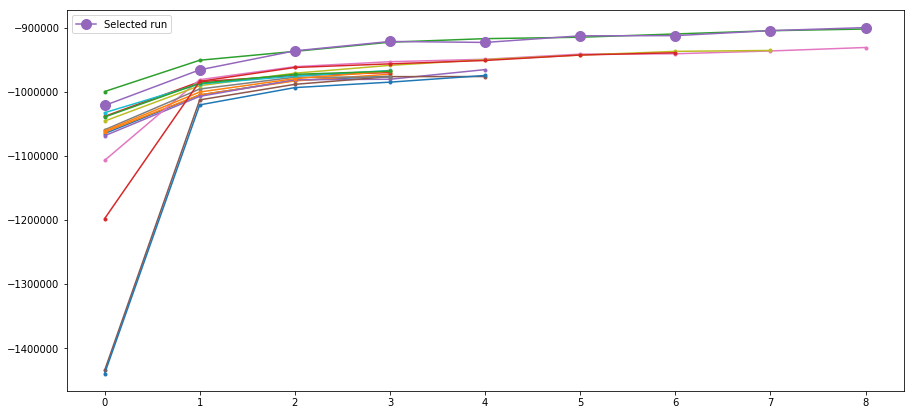

In [42]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [14]:
#Import it:
from code.evaluation import Evaluation_metrics

In [21]:
aux_tr = []
aux_te = []
for _ in range(10):
    model_UB = clone_UB.get_model()
    model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
    hist = model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
    Z_train_pred = model_UB.predict_classes(Xstd_train)
    Z_test_pred = model_UB.predict_classes(Xstd_test)

    evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0], plot=False)
    aux_tr += evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)
    aux_te += evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)
    
final_tr_m = get_mean_dataframes(aux_tr)#.to_csv("LabelMe_Ideal_train.csv",index=False)
final_tr_std = get_mean_dataframes(aux_tr, mean_std=False)#.to_csv("LabelMe_Ideal_train_std.csv",index=False)
final_te_m = get_mean_dataframes(aux_te)#.to_csv("LabelMe_Ideal_test.csv",index=False)
final_te_std = get_mean_dataframes(aux_te, mean_std=False)#.to_csv("LabelMe_Ideal_test_std.csv",index=False)
final_tr_m.merge(final_tr_std.iloc[:,1:], left_index=True, right_index=True)

,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.962568,0.962568,0.962532,0.023043,0.023043,0.02305


In [32]:
final_te_m.merge(final_te_std.iloc[:,1:], left_index=True, right_index=True) #cerca de 84

,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.83507,0.83507,0.834527,0.016259,0.016259,0.015944


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [15]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.73942


*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


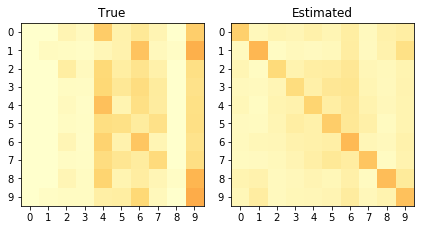

JS divergence: 0.173	Norm Frobenius: 0.096


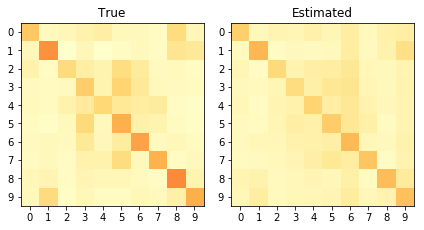

JS divergence: 0.037	Norm Frobenius: 0.049


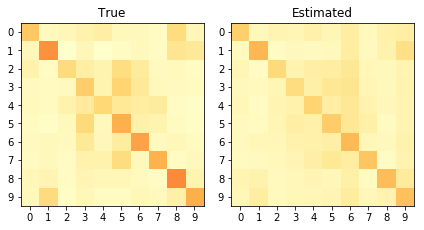

JS divergence: 0.037	Norm Frobenius: 0.049


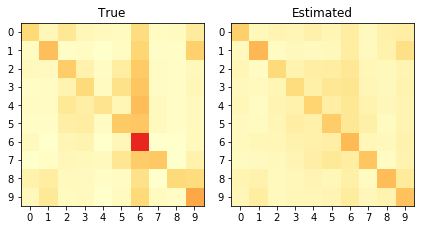

JS divergence: 0.072	Norm Frobenius: 0.068


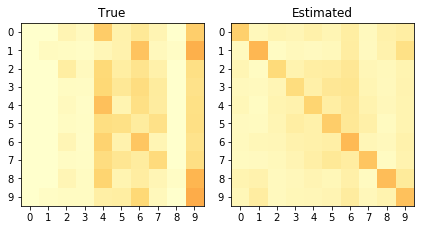

JS divergence: 0.173	Norm Frobenius: 0.096


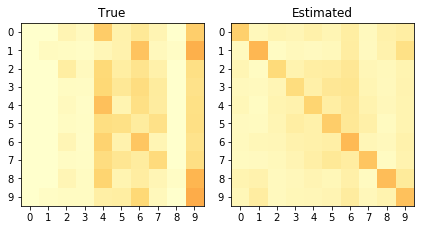

JS divergence: 0.173	Norm Frobenius: 0.096


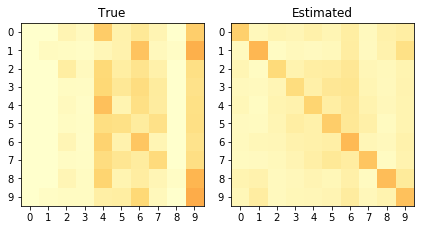

JS divergence: 0.173	Norm Frobenius: 0.096


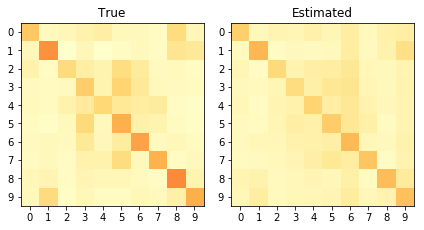

JS divergence: 0.037	Norm Frobenius: 0.049


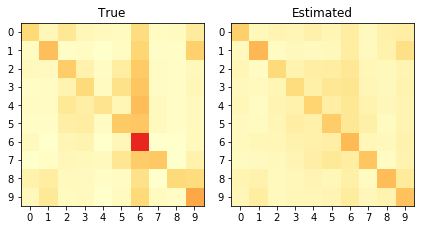

JS divergence: 0.072	Norm Frobenius: 0.068


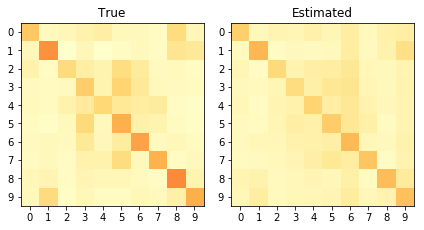

JS divergence: 0.037	Norm Frobenius: 0.049


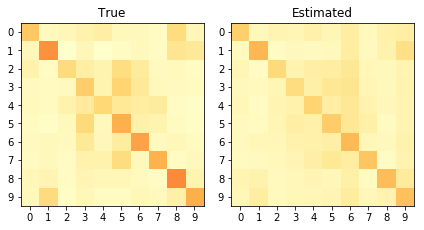

JS divergence: 0.037	Norm Frobenius: 0.049


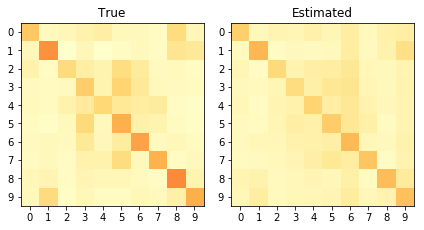

JS divergence: 0.037	Norm Frobenius: 0.049


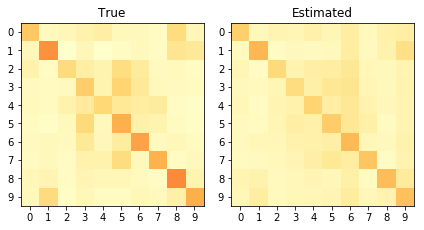

JS divergence: 0.037	Norm Frobenius: 0.049


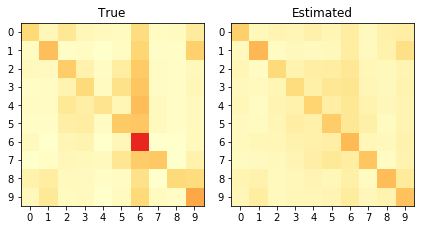

JS divergence: 0.072	Norm Frobenius: 0.068


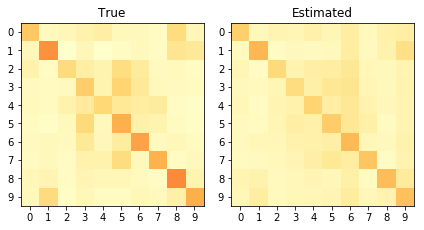

JS divergence: 0.037	Norm Frobenius: 0.049
Calculate confusion matrix on global version


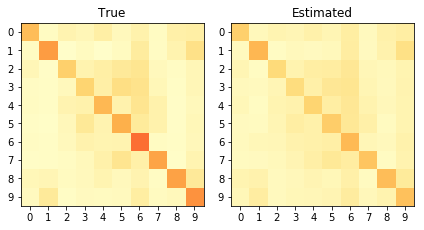

JS divergence: 0.017	Norm Frobenius: 0.039
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.547,0.547,0.5243,0.0828,0.1003,0.0828,0.1003,0.0395,0.0174


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5374,0.5374,0.5151


In [16]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


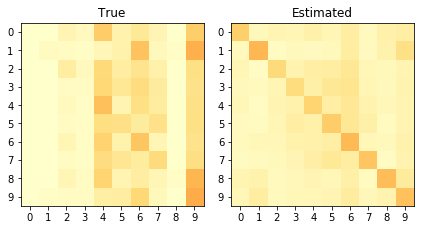

JS divergence: 0.1733	Norm Frobenius: 0.0963


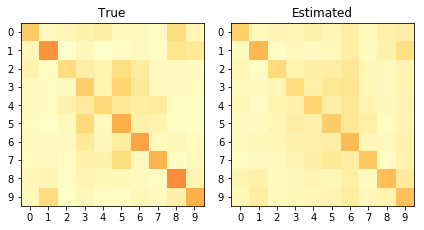

JS divergence: 0.0372	Norm Frobenius: 0.0489


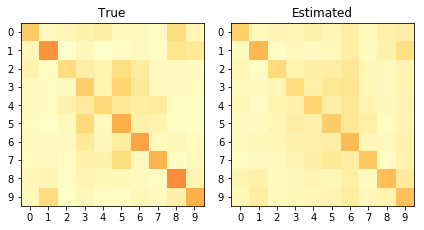

JS divergence: 0.0372	Norm Frobenius: 0.0489


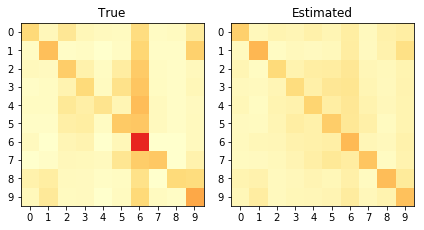

JS divergence: 0.0724	Norm Frobenius: 0.0684


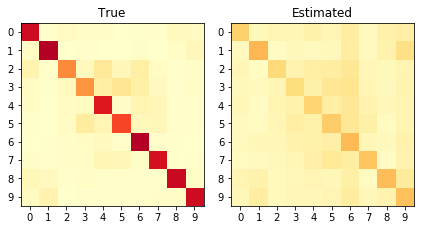

JS divergence: 0.1932	Norm Frobenius: 0.1552


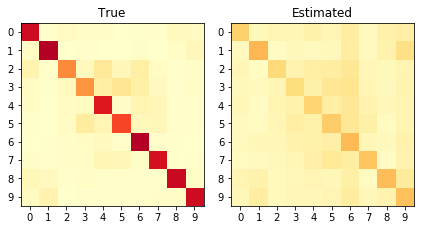

JS divergence: 0.1932	Norm Frobenius: 0.1552


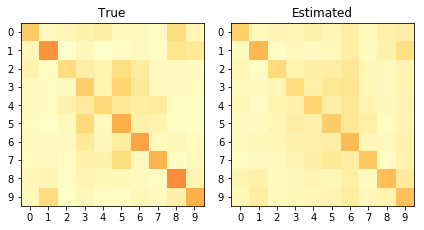

JS divergence: 0.0372	Norm Frobenius: 0.0489


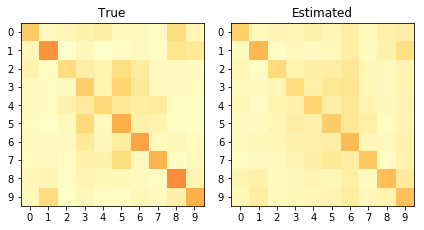

JS divergence: 0.0372	Norm Frobenius: 0.0489


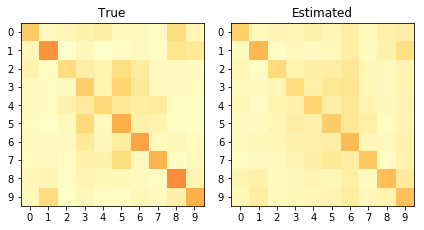

JS divergence: 0.0372	Norm Frobenius: 0.0489


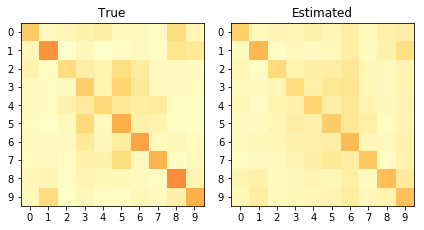

JS divergence: 0.0372	Norm Frobenius: 0.0489


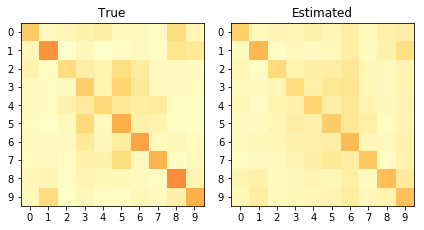

JS divergence: 0.0372	Norm Frobenius: 0.0489


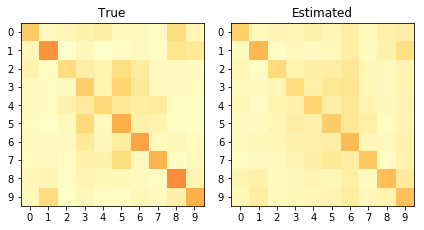

JS divergence: 0.0372	Norm Frobenius: 0.0489


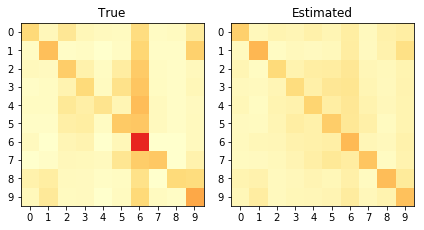

JS divergence: 0.0724	Norm Frobenius: 0.0684


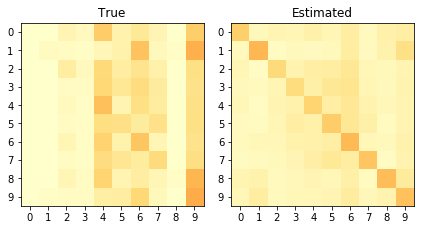

JS divergence: 0.1733	Norm Frobenius: 0.0963


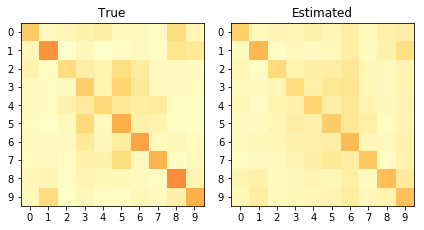

JS divergence: 0.0372	Norm Frobenius: 0.0489
Calculate confusion matrix on global version


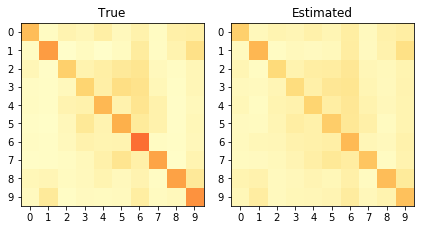

JS divergence: 0.0174	Norm Frobenius: 0.0395
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.55708,0.55708,0.082806,0.100303,0.082844,0.100314,0.039491,0.017418


Test
A result


,,Accuracy,F1 (micro)
0,All,0.5477,0.5477


In [14]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


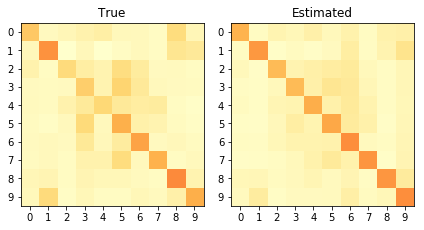

JS divergence: 0.0298	Norm Frobenius: 0.0457


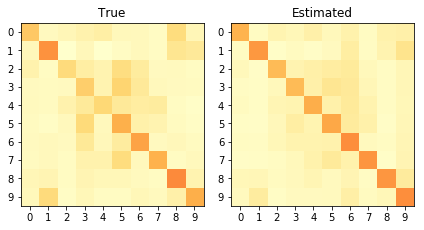

JS divergence: 0.0298	Norm Frobenius: 0.0457


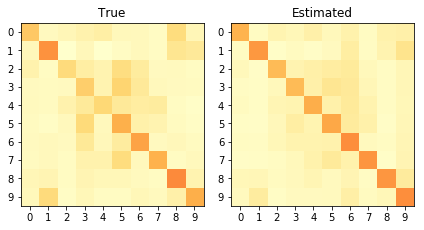

JS divergence: 0.0298	Norm Frobenius: 0.0457


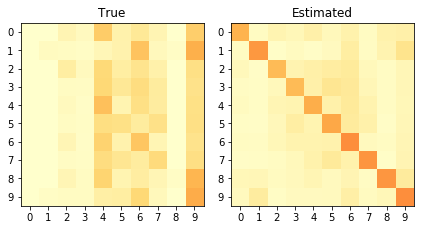

JS divergence: 0.1947	Norm Frobenius: 0.1199


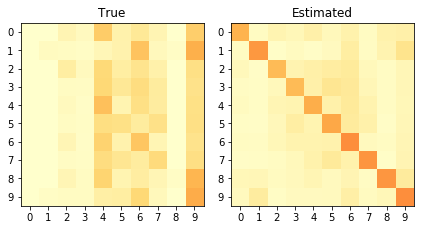

JS divergence: 0.1947	Norm Frobenius: 0.1199


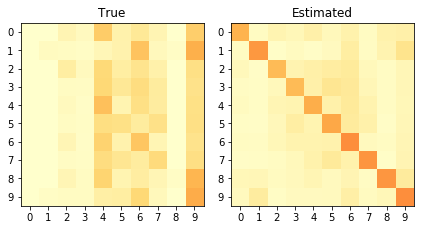

JS divergence: 0.1947	Norm Frobenius: 0.1199


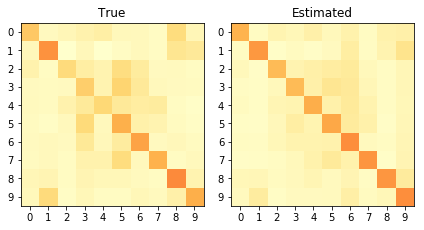

JS divergence: 0.0298	Norm Frobenius: 0.0457


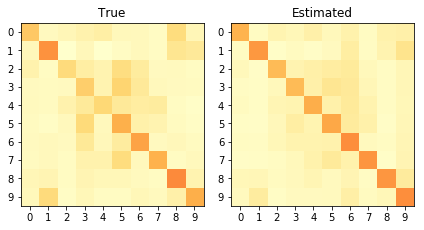

JS divergence: 0.0298	Norm Frobenius: 0.0457


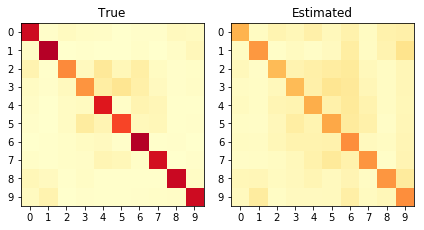

JS divergence: 0.1132	Norm Frobenius: 0.1147


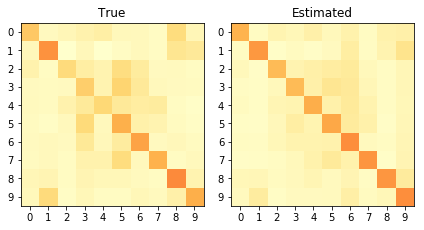

JS divergence: 0.0298	Norm Frobenius: 0.0457


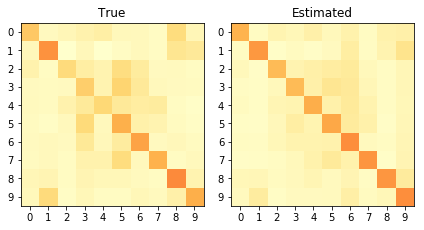

JS divergence: 0.0298	Norm Frobenius: 0.0457


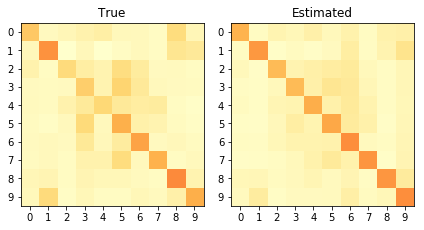

JS divergence: 0.0298	Norm Frobenius: 0.0457


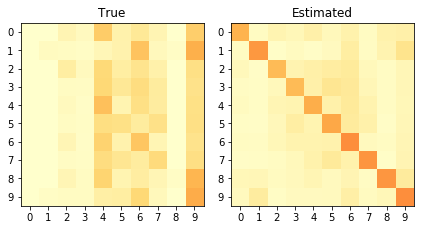

JS divergence: 0.1947	Norm Frobenius: 0.1199


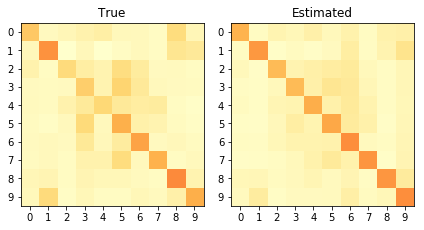

JS divergence: 0.0298	Norm Frobenius: 0.0457


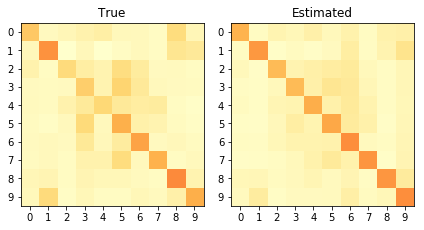

JS divergence: 0.0298	Norm Frobenius: 0.0457
Calculate confusion matrix on global version


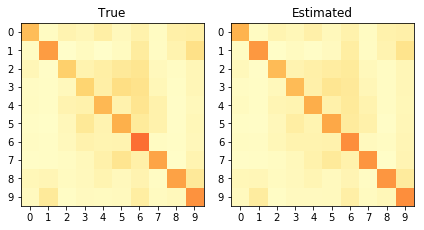

JS divergence: 0.0031	Norm Frobenius: 0.0186
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.70164,0.70164,0.079106,0.084253,0.079104,0.0842,0.01859,0.003086


Test
A result


,,Accuracy,F1 (micro)
0,All,0.6759,0.6759


In [16]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


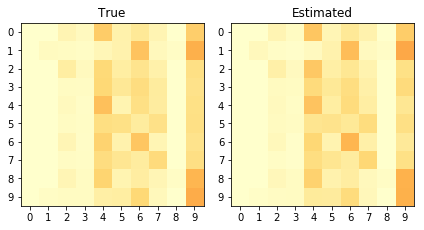

JS divergence: 0.0038	Norm Frobenius: 0.0163


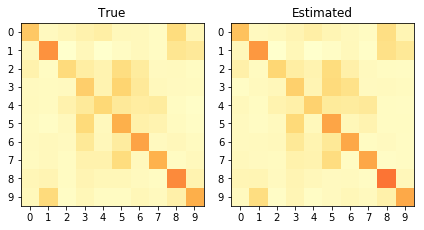

JS divergence: 0.0041	Norm Frobenius: 0.0150


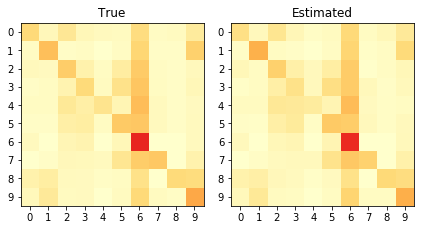

JS divergence: 0.0038	Norm Frobenius: 0.0145


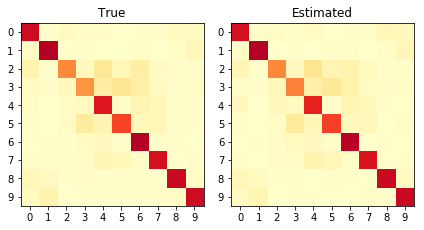

JS divergence: 0.0056	Norm Frobenius: 0.0107


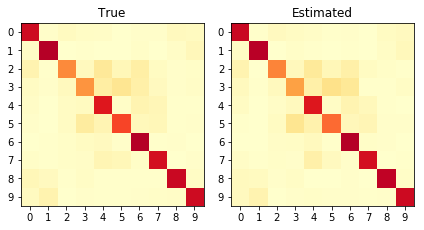

JS divergence: 0.0057	Norm Frobenius: 0.0140


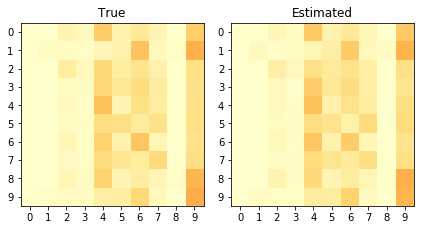

JS divergence: 0.0029	Norm Frobenius: 0.0135


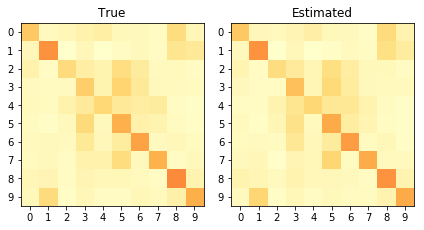

JS divergence: 0.0047	Norm Frobenius: 0.0156


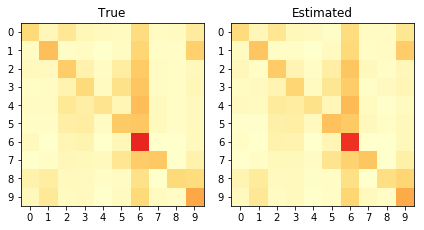

JS divergence: 0.0044	Norm Frobenius: 0.0123


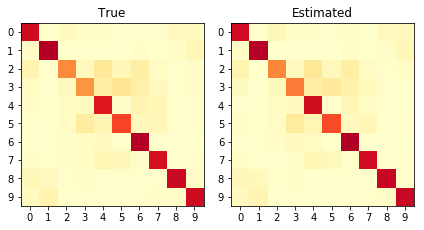

JS divergence: 0.0049	Norm Frobenius: 0.0105


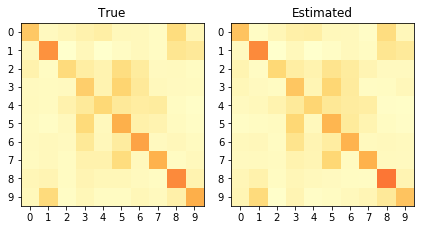

JS divergence: 0.0051	Norm Frobenius: 0.0167


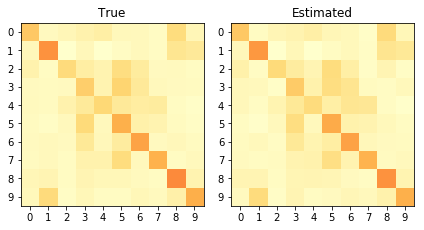

JS divergence: 0.0048	Norm Frobenius: 0.0137


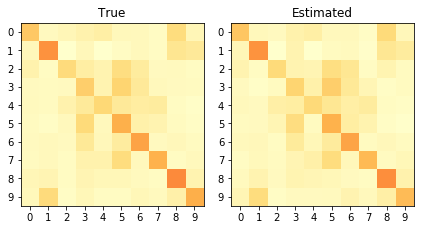

JS divergence: 0.0046	Norm Frobenius: 0.0132


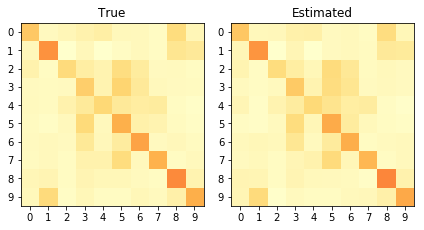

JS divergence: 0.0040	Norm Frobenius: 0.0128


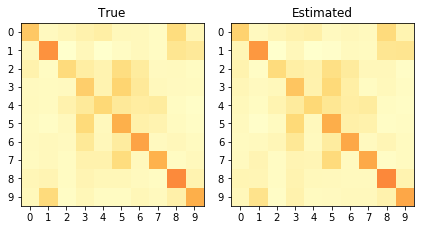

JS divergence: 0.0044	Norm Frobenius: 0.0136


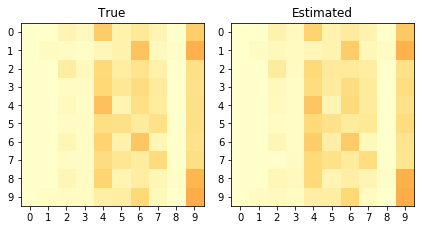

JS divergence: 0.0027	Norm Frobenius: 0.0135
Calculate confusion matrix on global version


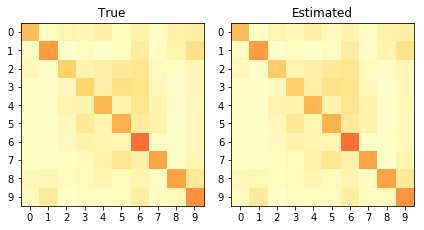

JS divergence: 0.0001	Norm Frobenius: 0.0023
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.77656,0.77656,0.014025,0.004426,0.014022,0.004426,0.002251,0.000054


Test
A result


,,Accuracy,F1 (micro)
0,All,0.7467,0.7467


In [18]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


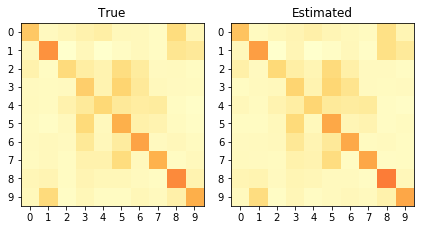

JS divergence: 0.0032	Norm Frobenius: 0.0131


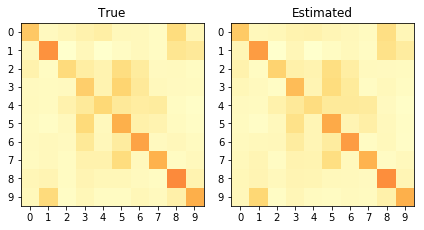

JS divergence: 0.0040	Norm Frobenius: 0.0146


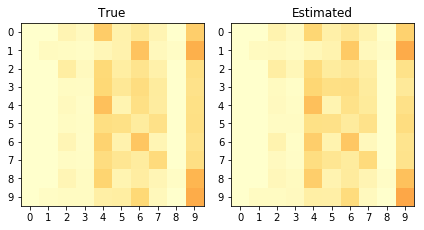

JS divergence: 0.0046	Norm Frobenius: 0.0121


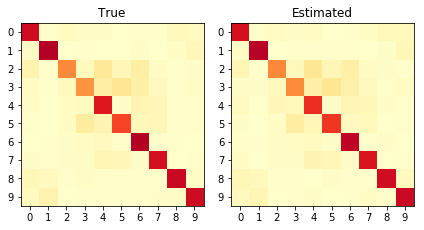

JS divergence: 0.0038	Norm Frobenius: 0.0110


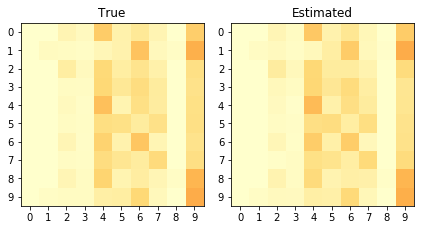

JS divergence: 0.0054	Norm Frobenius: 0.0127


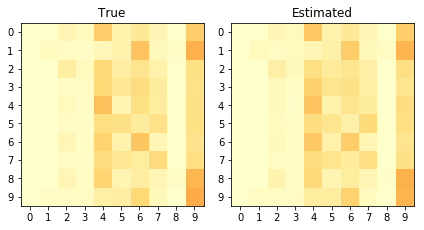

JS divergence: 0.0050	Norm Frobenius: 0.0128


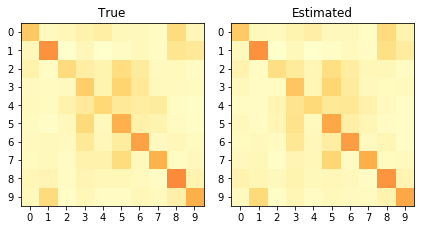

JS divergence: 0.0045	Norm Frobenius: 0.0148


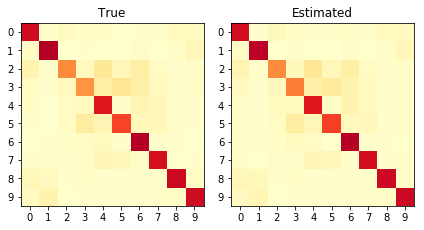

JS divergence: 0.0026	Norm Frobenius: 0.0088


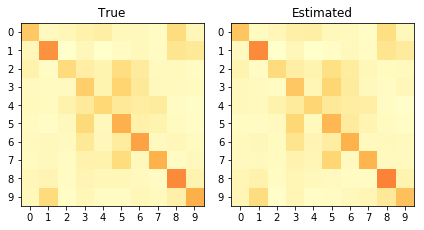

JS divergence: 0.0039	Norm Frobenius: 0.0144


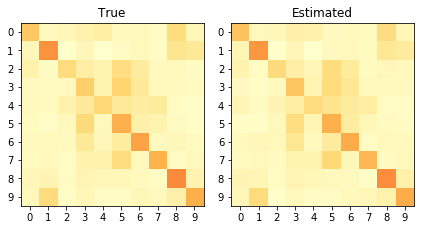

JS divergence: 0.0032	Norm Frobenius: 0.0120


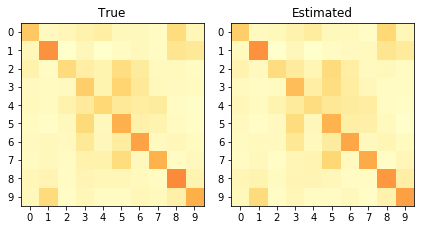

JS divergence: 0.0039	Norm Frobenius: 0.0150


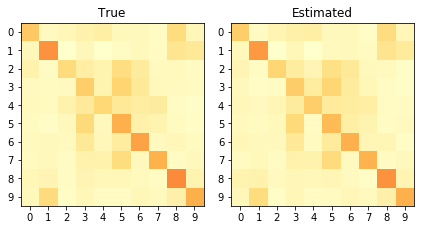

JS divergence: 0.0043	Norm Frobenius: 0.0133


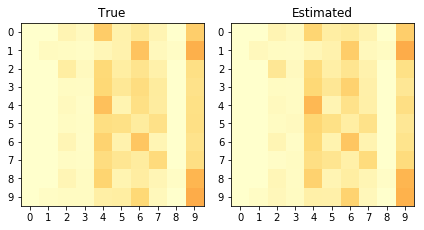

JS divergence: 0.0051	Norm Frobenius: 0.0140


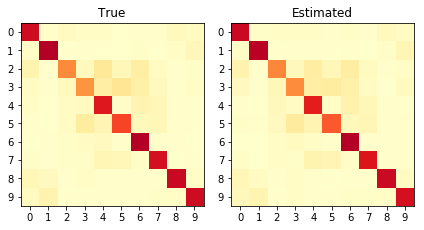

JS divergence: 0.0031	Norm Frobenius: 0.0103


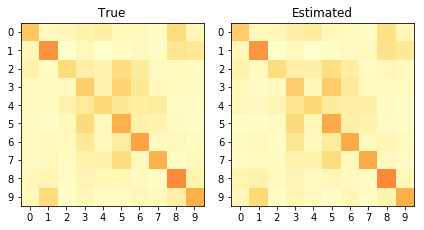

JS divergence: 0.0035	Norm Frobenius: 0.0114
Calculate confusion matrix on global version


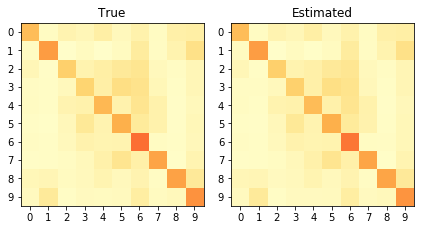

JS divergence: 0.0001	Norm Frobenius: 0.0031
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.83668,0.83668,0.012848,0.004118,0.012846,0.004116,0.003107,0.000136,0.225995,0.225949


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.398689,1.692161,0.398914,1.691797


Test
A result


,,Accuracy,F1 (micro)
0,All,0.7809,0.7809


In [22]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


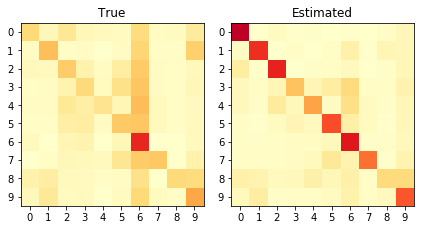

JS divergence: 0.118	Norm Frobenius: 0.119
Groups probabilities:  [0. 0. 1. 0.]


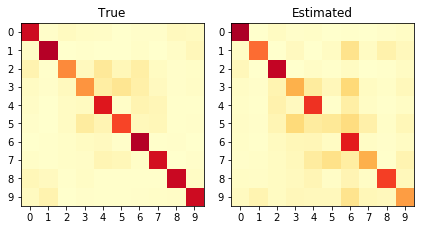

JS divergence: 0.104	Norm Frobenius: 0.105
Groups probabilities:  [1. 0. 0. 0.]


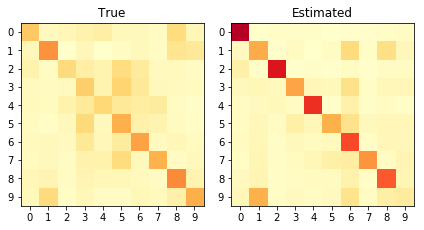

JS divergence: 0.123	Norm Frobenius: 0.118
Groups probabilities:  [0. 0. 0. 1.]


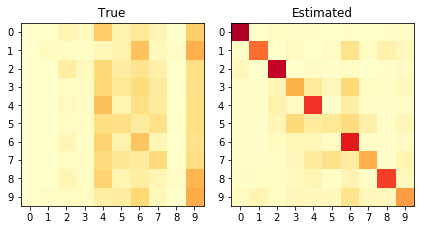

JS divergence: 0.321	Norm Frobenius: 0.187
Groups probabilities:  [1. 0. 0. 0.]


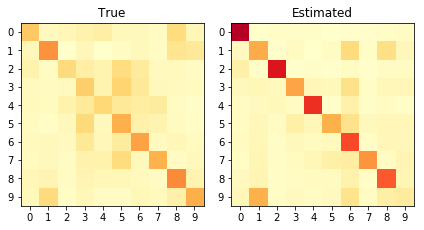

JS divergence: 0.123	Norm Frobenius: 0.118
Groups probabilities:  [0. 0. 0. 1.]


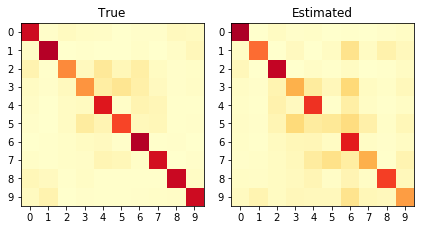

JS divergence: 0.104	Norm Frobenius: 0.105
Groups probabilities:  [1. 0. 0. 0.]


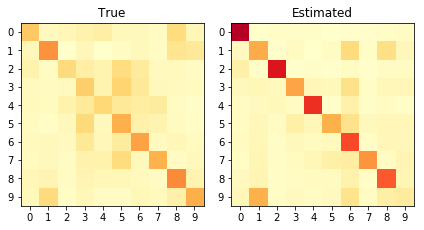

JS divergence: 0.123	Norm Frobenius: 0.118
Groups probabilities:  [0. 0. 0. 1.]


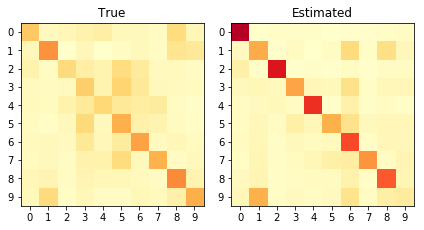

JS divergence: 0.123	Norm Frobenius: 0.118
Groups probabilities:  [0. 0. 0. 1.]


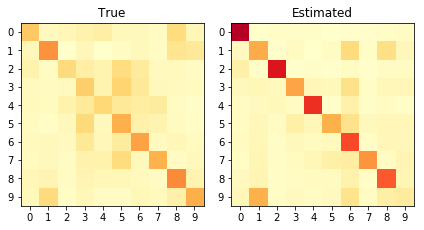

JS divergence: 0.123	Norm Frobenius: 0.118
Groups probabilities:  [0. 0. 0. 1.]


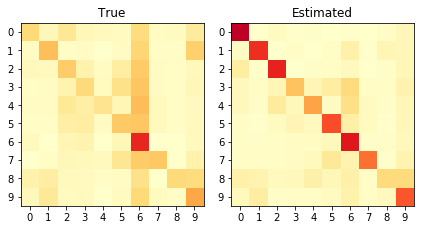

JS divergence: 0.118	Norm Frobenius: 0.119
Groups probabilities:  [0. 0. 1. 0.]


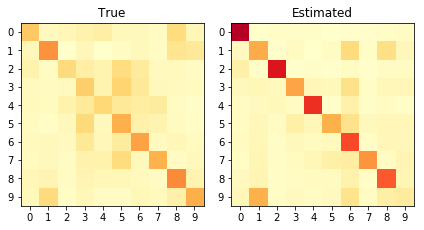

JS divergence: 0.123	Norm Frobenius: 0.118
Groups probabilities:  [0. 0. 0. 1.]


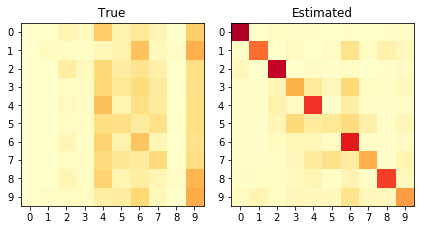

JS divergence: 0.321	Norm Frobenius: 0.187
Groups probabilities:  [1. 0. 0. 0.]


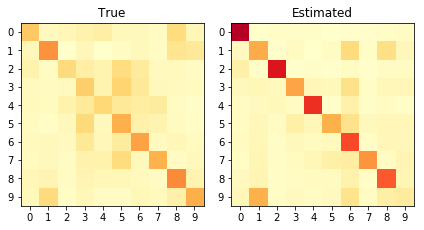

JS divergence: 0.123	Norm Frobenius: 0.118
Groups probabilities:  [0. 0. 0. 1.]


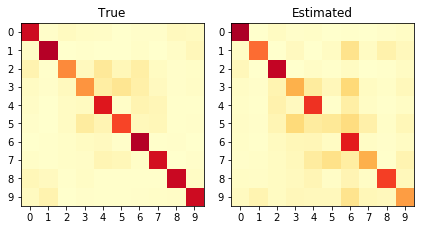

JS divergence: 0.104	Norm Frobenius: 0.105
Groups probabilities:  [1. 0. 0. 0.]


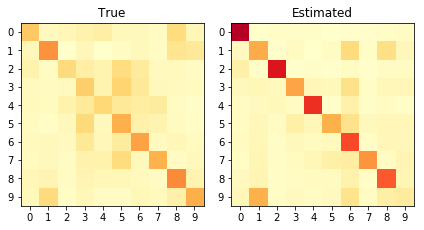

JS divergence: 0.123	Norm Frobenius: 0.118
Groups probabilities:  [0. 0. 0. 1.]
Calculate confusion matrix on global version


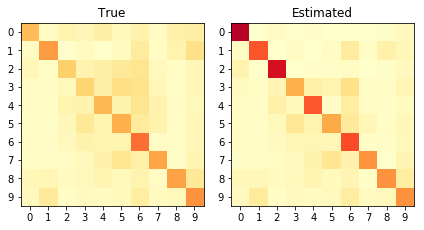

JS divergence: 0.069	Norm Frobenius: 0.091
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.7736,0.7736,0.7443,0.128,0.1539,0.128,0.1538,0.0911,0.0686,0.304,0.3037


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.3544,0.3544,0.306,0.3547,0.3547,0.3063


Test


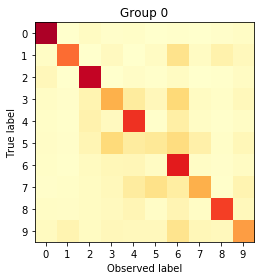

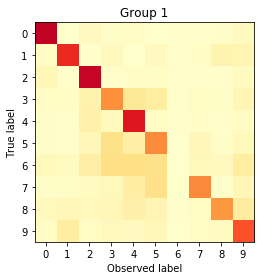

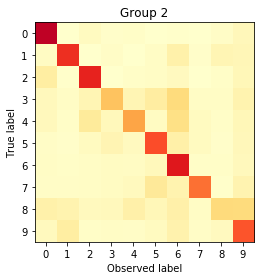

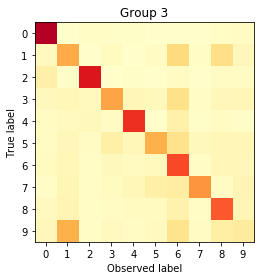

Inertia JS: 0.09249909515717343
Inertia NormF: 0.09381218000096003
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.3749,37,1.3403,0.5781,0.7238,0.5312,0.1031,6,0.0925,0.0938,0.6726,0.6726
1,1,0.1431,14,1.3362,0.5764,0.7069,0.5293,0.0383,4,0.0925,0.0938,0.6639,0.6639
2,2,0.3486,34,1.3905,0.5815,0.7338,0.5350,0.0658,6,0.0925,0.0938,0.5990,0.5990
3,3,0.1334,13,1.4627,0.5397,0.6972,0.4885,0.0783,6,0.0925,0.0938,0.6380,0.6380


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7186,0.7186,0.6858


In [54]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual-T multiples runs***
Train
Calculate confusion matrix on repeat version


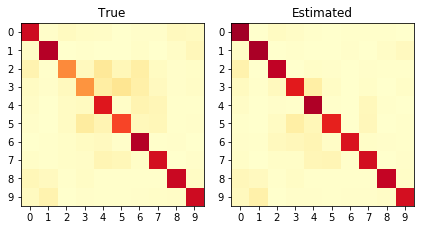

JS divergence: 0.040	Norm Frobenius: 0.058
Groups probabilities:  [0.97 0.02 0.   0.  ]


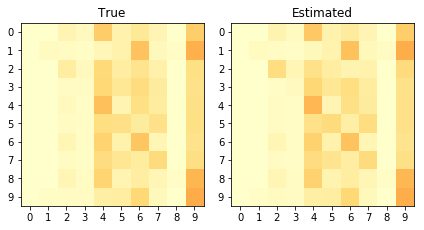

JS divergence: 0.004	Norm Frobenius: 0.017
Groups probabilities:  [0. 0. 1. 0.]


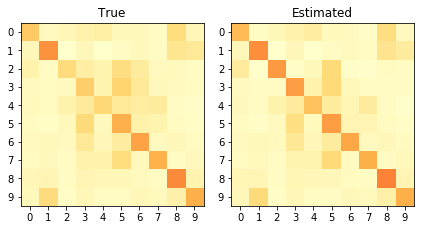

JS divergence: 0.016	Norm Frobenius: 0.036
Groups probabilities:  [0.05 0.88 0.05 0.03]


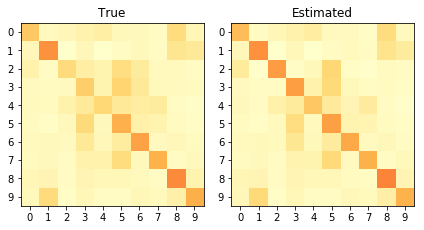

JS divergence: 0.016	Norm Frobenius: 0.035
Groups probabilities:  [0.03 0.9  0.04 0.03]


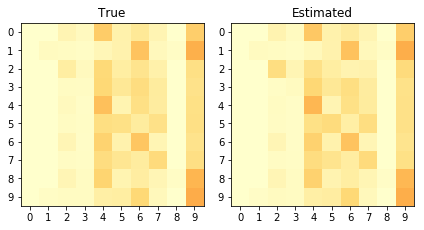

JS divergence: 0.004	Norm Frobenius: 0.017
Groups probabilities:  [0. 0. 1. 0.]


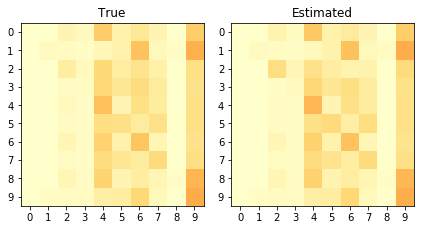

JS divergence: 0.004	Norm Frobenius: 0.017
Groups probabilities:  [0. 0. 1. 0.]


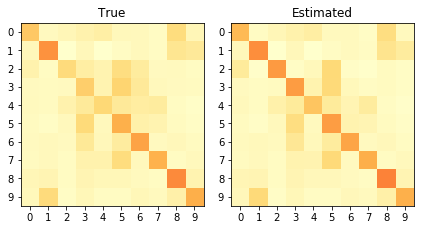

JS divergence: 0.016	Norm Frobenius: 0.036
Groups probabilities:  [0.04 0.88 0.03 0.05]


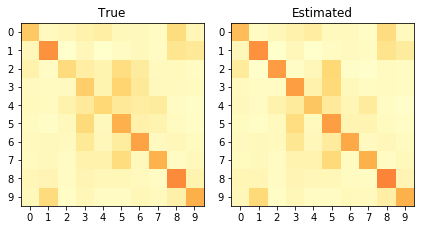

JS divergence: 0.016	Norm Frobenius: 0.035
Groups probabilities:  [0.03 0.9  0.04 0.02]


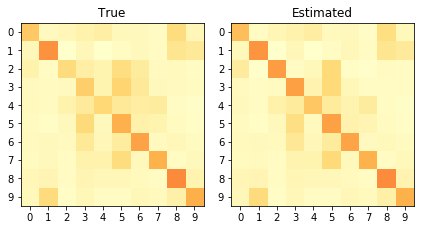

JS divergence: 0.014	Norm Frobenius: 0.034
Groups probabilities:  [0.03 0.85 0.05 0.07]


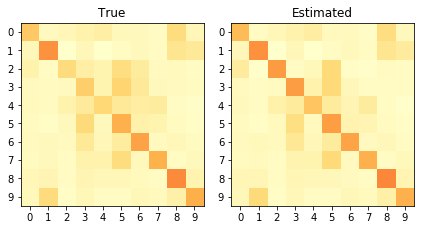

JS divergence: 0.015	Norm Frobenius: 0.035
Groups probabilities:  [0.04 0.87 0.04 0.05]


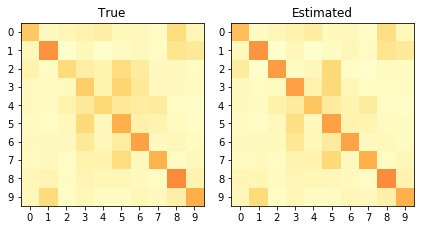

JS divergence: 0.014	Norm Frobenius: 0.034
Groups probabilities:  [0.04 0.84 0.06 0.06]


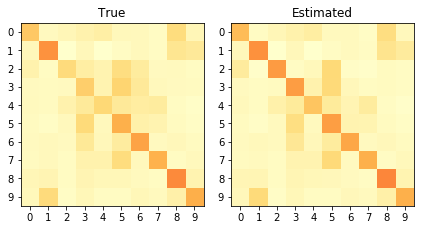

JS divergence: 0.015	Norm Frobenius: 0.035
Groups probabilities:  [0.04 0.87 0.04 0.04]


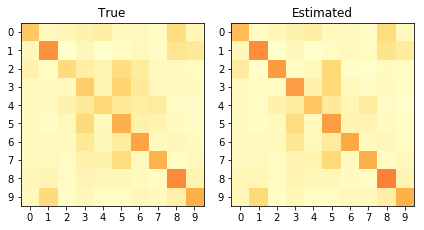

JS divergence: 0.017	Norm Frobenius: 0.036
Groups probabilities:  [0.04 0.9  0.03 0.03]


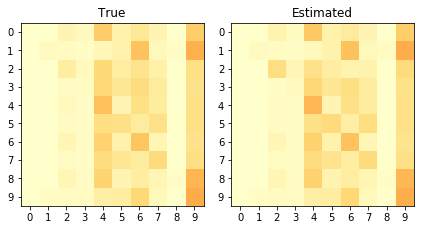

JS divergence: 0.004	Norm Frobenius: 0.017
Groups probabilities:  [0. 0. 1. 0.]


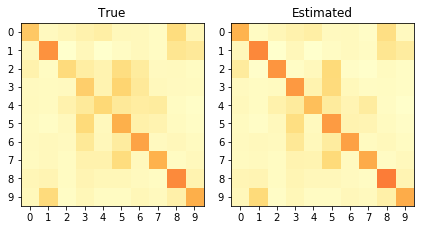

JS divergence: 0.018	Norm Frobenius: 0.039
Groups probabilities:  [0.07 0.85 0.02 0.05]
Calculate confusion matrix on global version


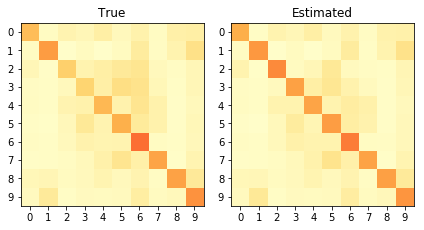

JS divergence: 0.011	Norm Frobenius: 0.036
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.8598,0.8598,0.851,0.0382,0.0189,0.0382,0.0189,0.0358,0.0114,0.3215,0.3215


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.412,0.412,0.3563,0.4122,0.4122,0.3567


Test


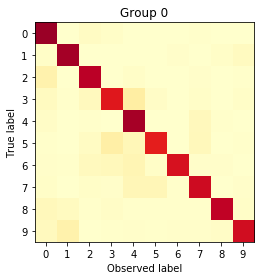

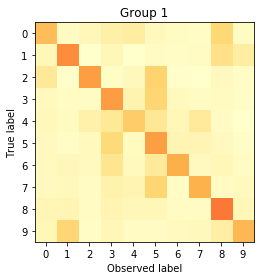

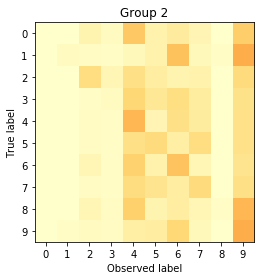

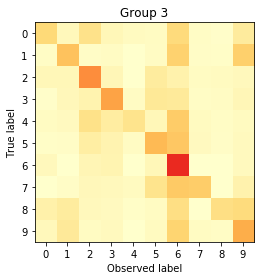

Inertia JS: 0.29535741412573274
Inertia NormF: 0.16176946640792458
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.2205,22,0.6543,0.8450,0.9167,0.8278,0.0283,4,0.2954,0.1618,0.8094,0.8094
1,1,0.3649,36,1.7380,0.4107,0.6105,0.3452,0.0843,5,0.2954,0.1618,0.7522,0.7522
2,2,0.1989,19,1.7046,0.1820,0.3218,0.0911,0.1775,9,0.2954,0.1618,0.3617,0.3617
3,3,0.2156,21,1.6977,0.3617,0.5536,0.2907,0.1925,6,0.2954,0.1618,0.3427,0.3427


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8025,0.8025,0.7932


In [78]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-T multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual-K multiples runs***
Train
Calculate confusion matrix on repeat version


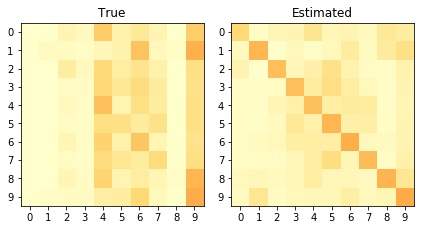

JS divergence: 0.170	Norm Frobenius: 0.102
Groups probabilities:  [0. 0. 0. 1.]


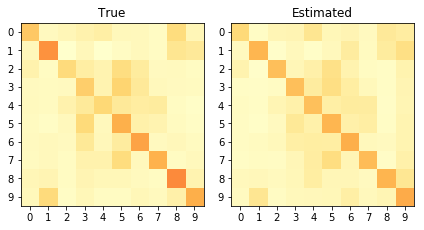

JS divergence: 0.027	Norm Frobenius: 0.041
Groups probabilities:  [0. 0. 0. 1.]


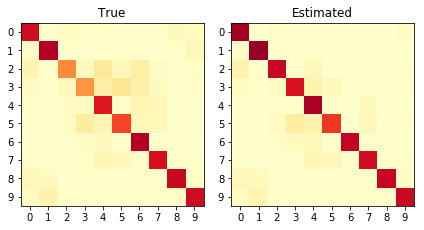

JS divergence: 0.038	Norm Frobenius: 0.056
Groups probabilities:  [1. 0. 0. 0.]


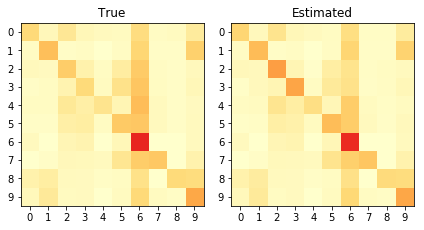

JS divergence: 0.007	Norm Frobenius: 0.031
Groups probabilities:  [0. 0. 1. 0.]


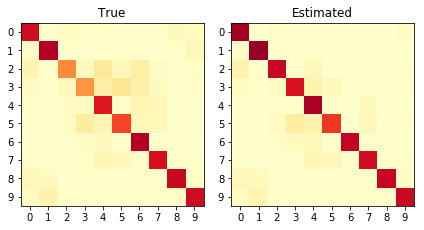

JS divergence: 0.038	Norm Frobenius: 0.056
Groups probabilities:  [1. 0. 0. 0.]


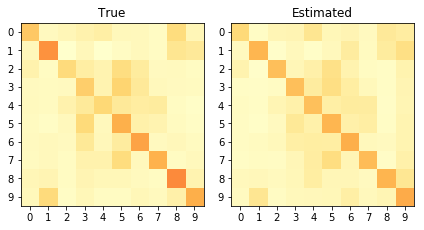

JS divergence: 0.027	Norm Frobenius: 0.041
Groups probabilities:  [0. 0. 0. 1.]


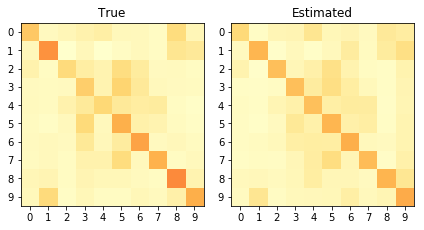

JS divergence: 0.027	Norm Frobenius: 0.041
Groups probabilities:  [0. 0. 0. 1.]


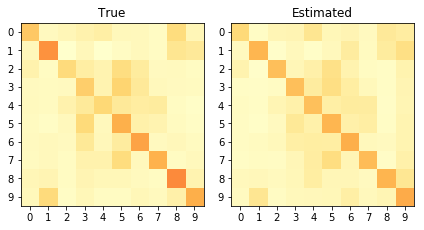

JS divergence: 0.027	Norm Frobenius: 0.041
Groups probabilities:  [0. 0. 0. 1.]


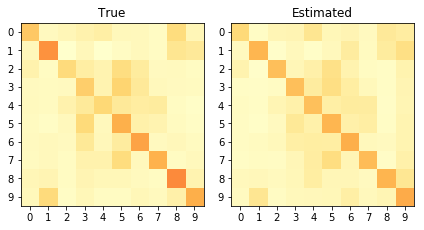

JS divergence: 0.027	Norm Frobenius: 0.041
Groups probabilities:  [0. 0. 0. 1.]


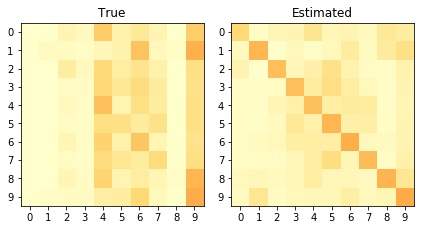

JS divergence: 0.170	Norm Frobenius: 0.102
Groups probabilities:  [0. 0. 0. 1.]


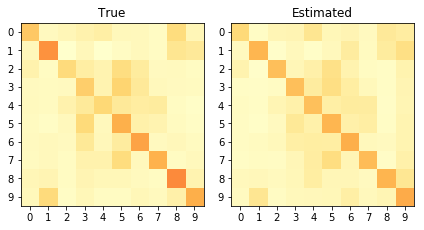

JS divergence: 0.027	Norm Frobenius: 0.041
Groups probabilities:  [0. 0. 0. 1.]


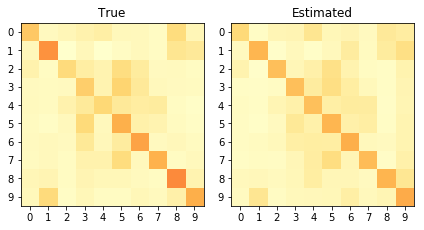

JS divergence: 0.027	Norm Frobenius: 0.041
Groups probabilities:  [0. 0. 0. 1.]


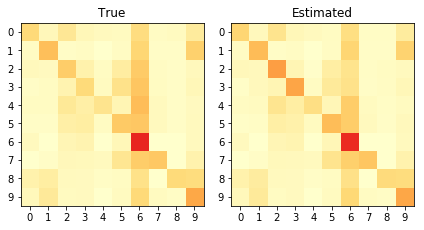

JS divergence: 0.007	Norm Frobenius: 0.031
Groups probabilities:  [0. 0. 1. 0.]


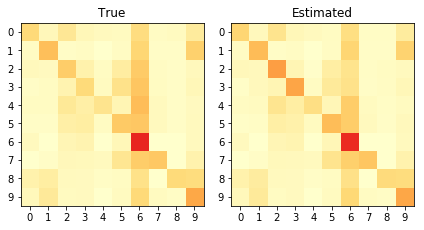

JS divergence: 0.007	Norm Frobenius: 0.031
Groups probabilities:  [0. 0. 1. 0.]


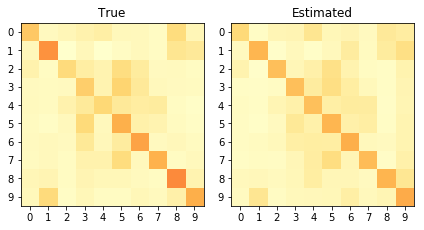

JS divergence: 0.027	Norm Frobenius: 0.041
Groups probabilities:  [0. 0. 0. 1.]
Calculate confusion matrix on global version


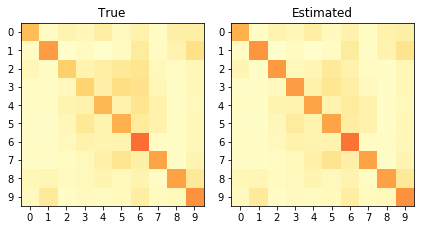

JS divergence: 0.007	Norm Frobenius: 0.030
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.8306,0.8306,0.8162,0.0526,0.0506,0.0526,0.0505,0.0304,0.0071,0.3504,0.35


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.3842,0.3842,0.3399,0.3845,0.3845,0.3403


Test


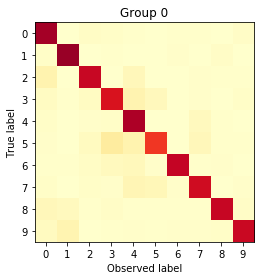

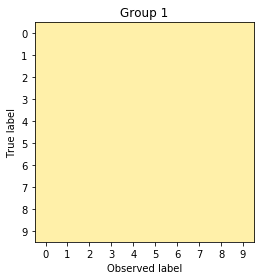

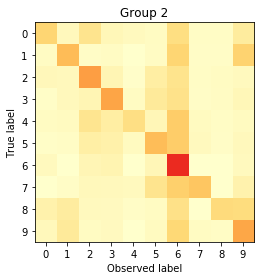

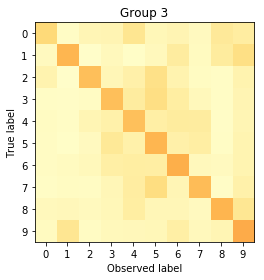

Inertia JS: 0.24395647613744612
Inertia NormF: 0.14984102269843075
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.20,20,0.6768,0.8422,0.9150,0.8247,0.0286,4,0.244,0.1498,0.7926,0.7926
1,1,0.00,0,2.3026,0.1000,0.2417,0.0000,0.0000,9,0.244,0.1498,0.1943,0.1943
2,2,0.21,21,1.7118,0.3671,0.5618,0.2967,0.1958,6,0.244,0.1498,0.5130,0.5130
3,3,0.59,58,1.9332,0.3443,0.5503,0.2714,0.0476,5,0.244,0.1498,0.7208,0.7208


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7731,0.7731,0.7567


In [64]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-K multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [76]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R_ob)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

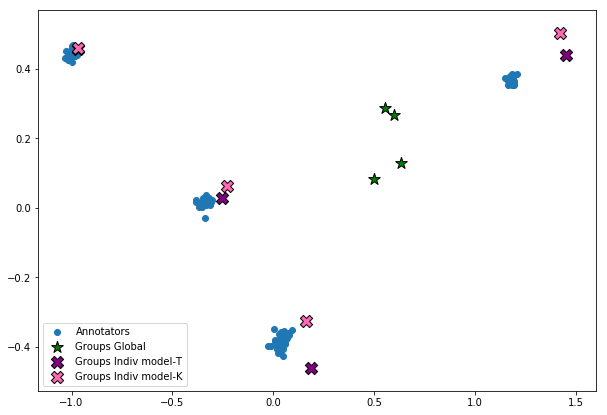

In [77]:
#model T se mantiene??
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [28]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.64792


#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [28]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7487


#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [36]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.73802


*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


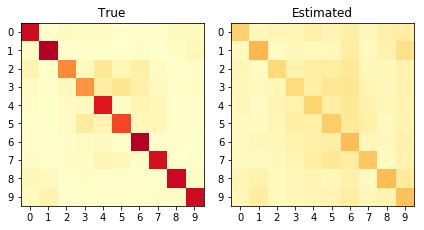

JS divergence: 0.1933	Norm Frobenius: 0.1551


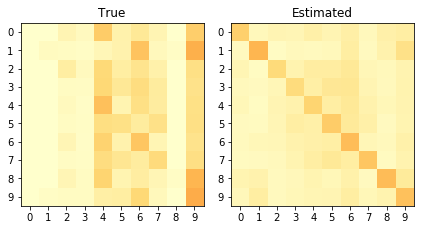

JS divergence: 0.1716	Norm Frobenius: 0.0960


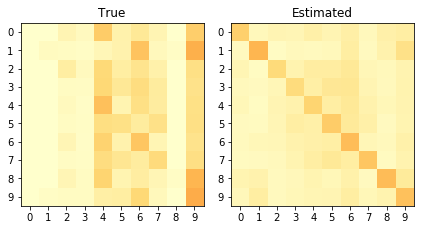

JS divergence: 0.1716	Norm Frobenius: 0.0960


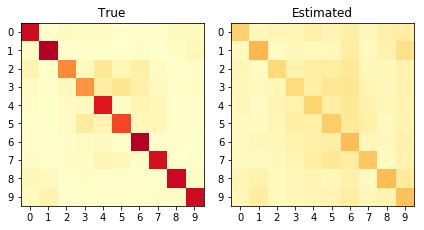

JS divergence: 0.1933	Norm Frobenius: 0.1551


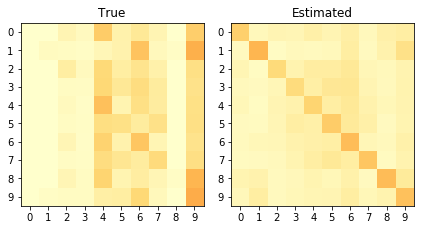

JS divergence: 0.1716	Norm Frobenius: 0.0960


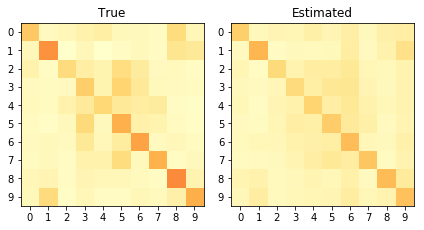

JS divergence: 0.0370	Norm Frobenius: 0.0484


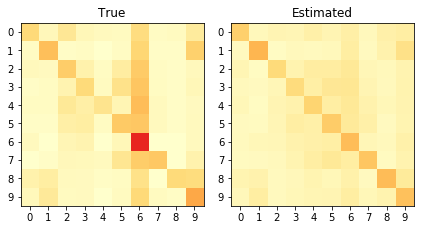

JS divergence: 0.0788	Norm Frobenius: 0.0715


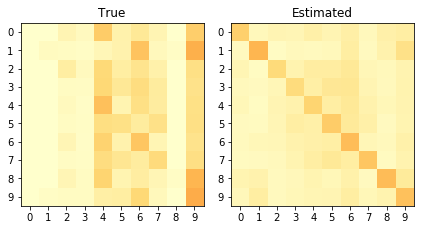

JS divergence: 0.1716	Norm Frobenius: 0.0960


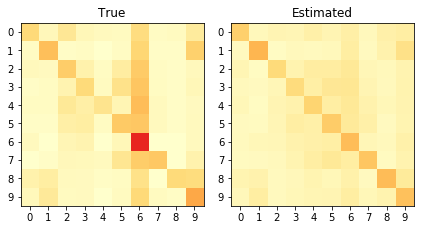

JS divergence: 0.0788	Norm Frobenius: 0.0715


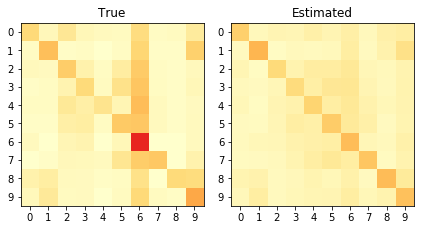

JS divergence: 0.0788	Norm Frobenius: 0.0715


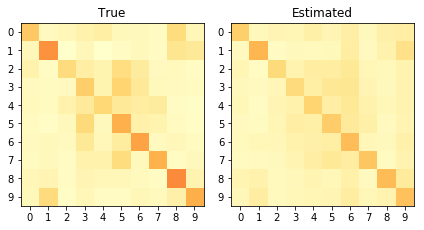

JS divergence: 0.0370	Norm Frobenius: 0.0484


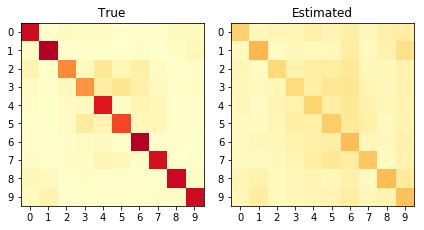

JS divergence: 0.1933	Norm Frobenius: 0.1551


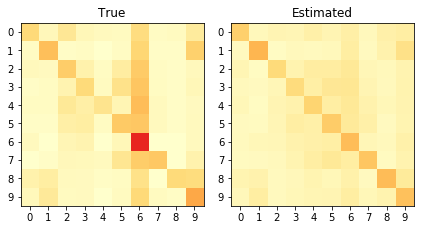

JS divergence: 0.0788	Norm Frobenius: 0.0715


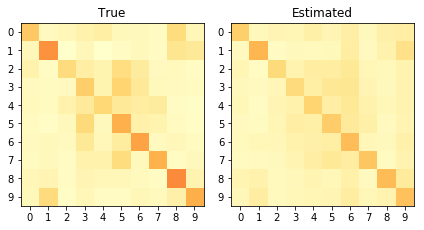

JS divergence: 0.0370	Norm Frobenius: 0.0484


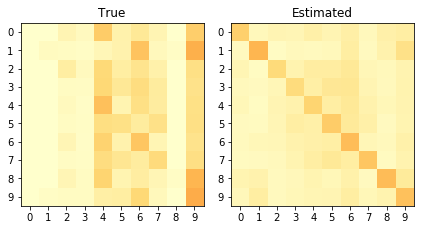

JS divergence: 0.1716	Norm Frobenius: 0.0960
Calculate confusion matrix on global version


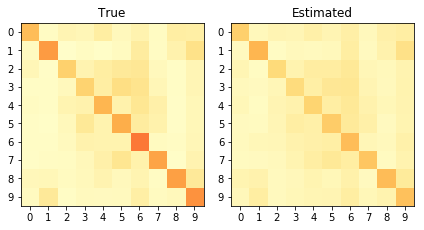

JS divergence: 0.0176	Norm Frobenius: 0.0393
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.5734,0.5734,0.083385,0.102427,0.083463,0.102566,0.039286,0.017568


Test
A result


,,Accuracy,F1 (micro)
0,All,0.5603,0.5603


In [37]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


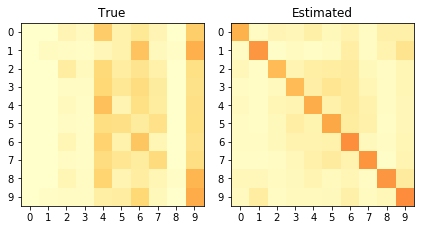

JS divergence: 0.1931	Norm Frobenius: 0.1199


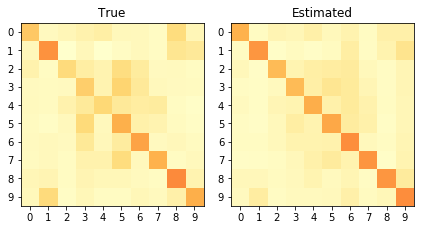

JS divergence: 0.0294	Norm Frobenius: 0.0454


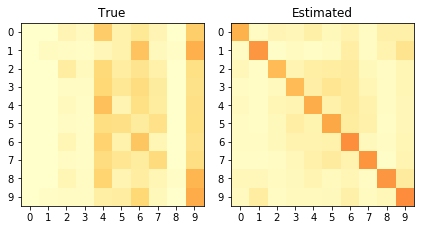

JS divergence: 0.1931	Norm Frobenius: 0.1199


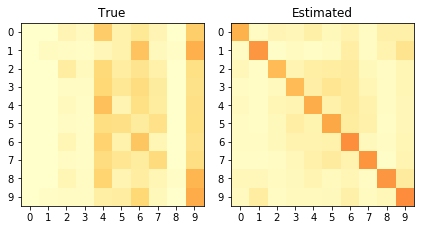

JS divergence: 0.1931	Norm Frobenius: 0.1199


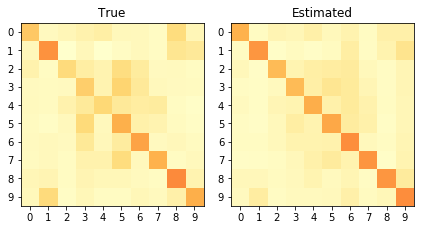

JS divergence: 0.0294	Norm Frobenius: 0.0454


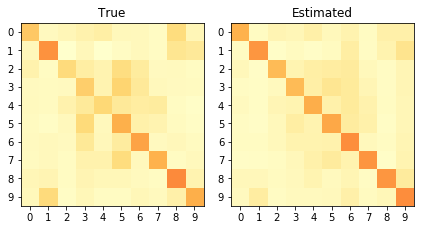

JS divergence: 0.0294	Norm Frobenius: 0.0454


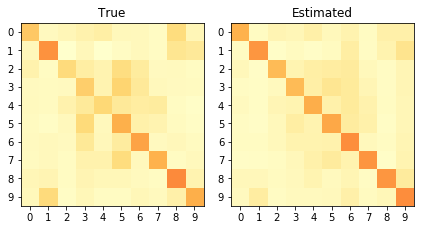

JS divergence: 0.0294	Norm Frobenius: 0.0454


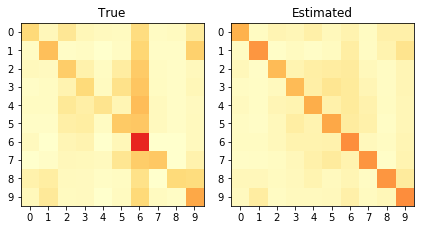

JS divergence: 0.0743	Norm Frobenius: 0.0776


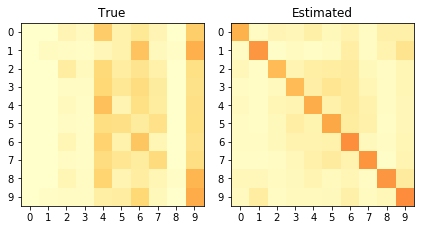

JS divergence: 0.1931	Norm Frobenius: 0.1199


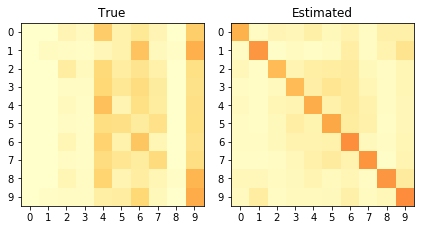

JS divergence: 0.1931	Norm Frobenius: 0.1199


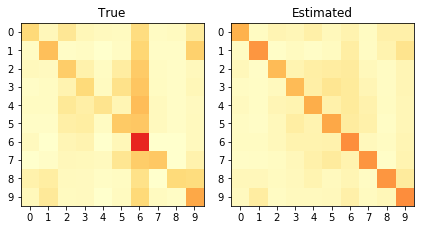

JS divergence: 0.0743	Norm Frobenius: 0.0776


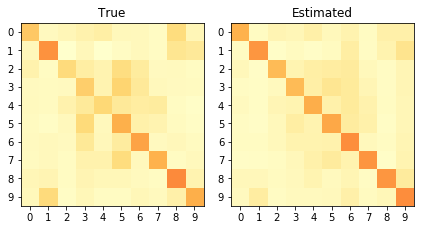

JS divergence: 0.0294	Norm Frobenius: 0.0454


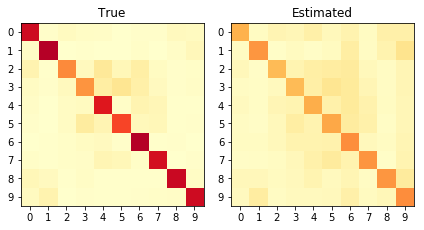

JS divergence: 0.1129	Norm Frobenius: 0.1142


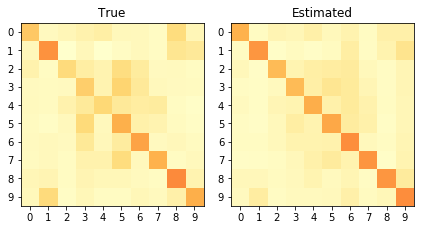

JS divergence: 0.0294	Norm Frobenius: 0.0454


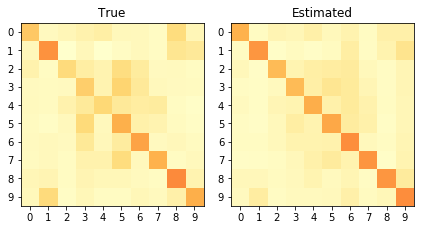

JS divergence: 0.0294	Norm Frobenius: 0.0454
Calculate confusion matrix on global version


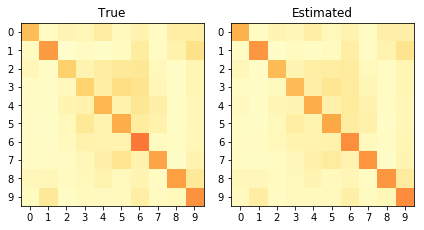

JS divergence: 0.0029	Norm Frobenius: 0.0176
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.65324,0.65324,0.079277,0.086105,0.079359,0.086228,0.017613,0.002941


Test
A result


,,Accuracy,F1 (micro)
0,All,0.629,0.629


In [39]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


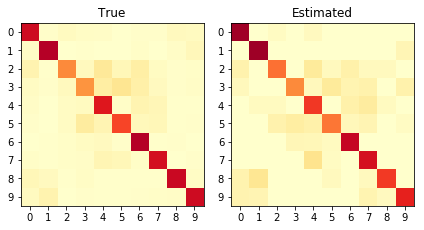

JS divergence: 0.0527	Norm Frobenius: 0.0389


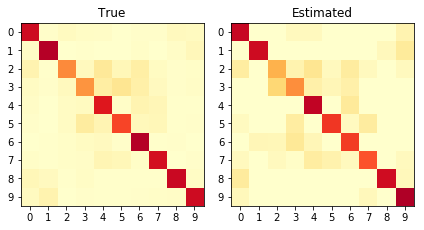

JS divergence: 0.0692	Norm Frobenius: 0.0516


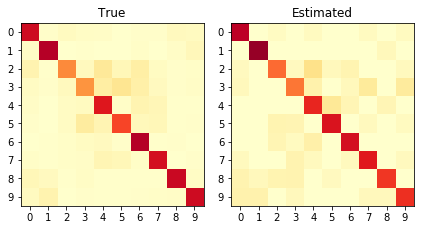

JS divergence: 0.0799	Norm Frobenius: 0.0480


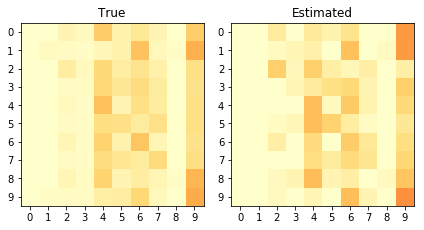

JS divergence: 0.0684	Norm Frobenius: 0.0566


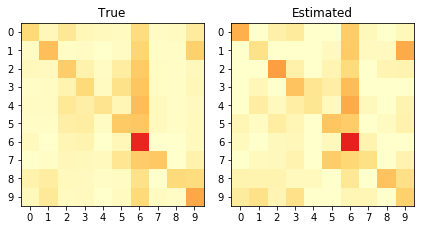

JS divergence: 0.0880	Norm Frobenius: 0.0592


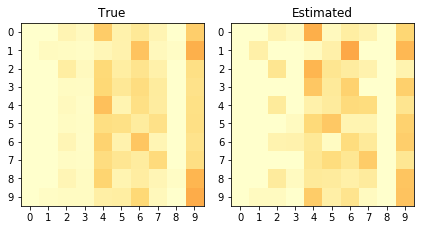

JS divergence: 0.0604	Norm Frobenius: 0.0591


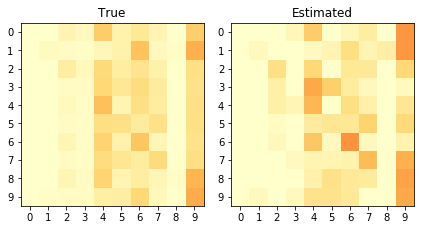

JS divergence: 0.0785	Norm Frobenius: 0.0652


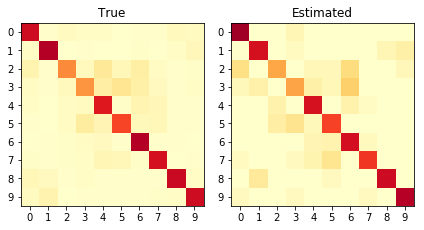

JS divergence: 0.0814	Norm Frobenius: 0.0491


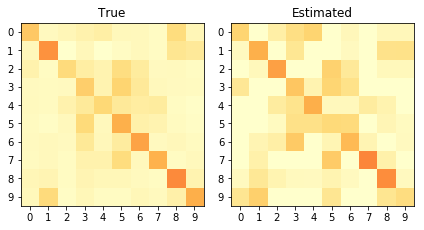

JS divergence: 0.1299	Norm Frobenius: 0.0709


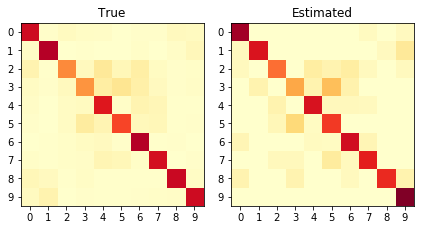

JS divergence: 0.0735	Norm Frobenius: 0.0467


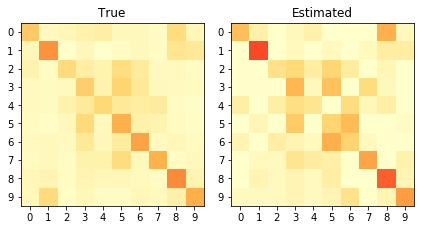

JS divergence: 0.1290	Norm Frobenius: 0.0742


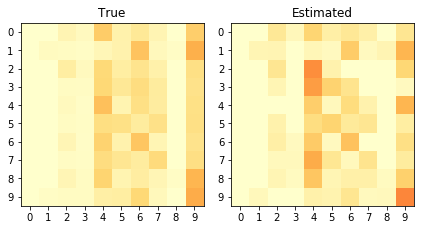

JS divergence: 0.0674	Norm Frobenius: 0.0617


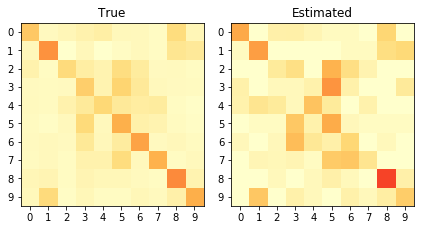

JS divergence: 0.1194	Norm Frobenius: 0.0748


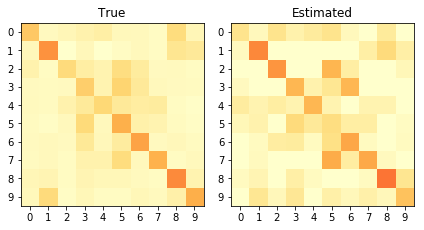

JS divergence: 0.1230	Norm Frobenius: 0.0692


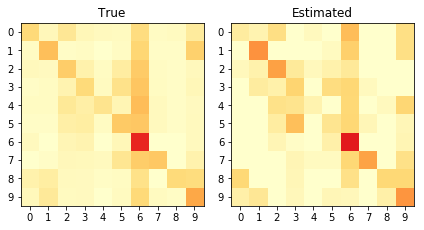

JS divergence: 0.1018	Norm Frobenius: 0.0664
Calculate confusion matrix on global version


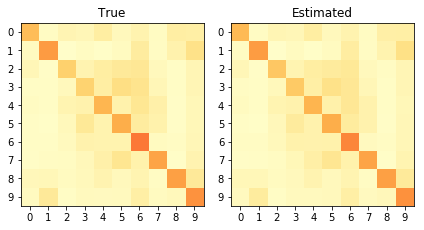

JS divergence: 0.0005	Norm Frobenius: 0.0069
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.75084,0.75084,0.063794,0.094756,0.063665,0.094388,0.006947,0.000513


Test
A result


,,Accuracy,F1 (micro)
0,All,0.7256,0.7256


In [41]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


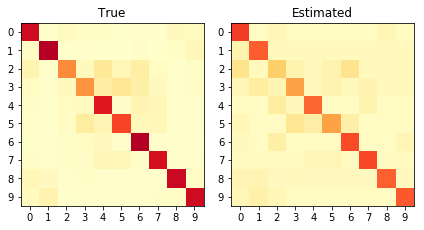

JS divergence: 0.0773	Norm Frobenius: 0.0762


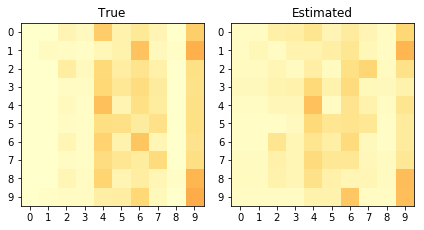

JS divergence: 0.0763	Norm Frobenius: 0.0527


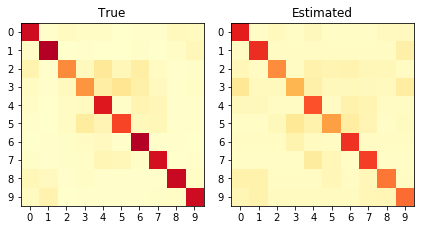

JS divergence: 0.0574	Norm Frobenius: 0.0655


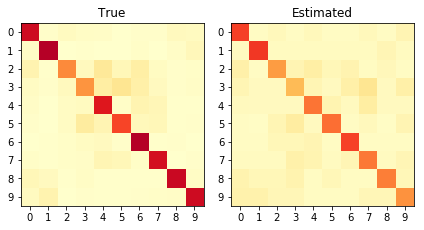

JS divergence: 0.0789	Norm Frobenius: 0.0778


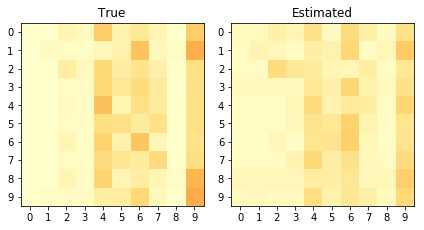

JS divergence: 0.0815	Norm Frobenius: 0.0589


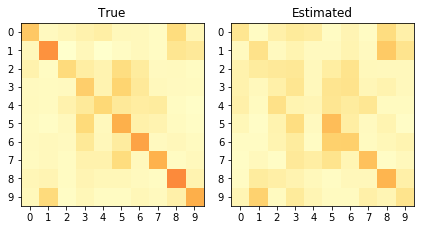

JS divergence: 0.0504	Norm Frobenius: 0.0638


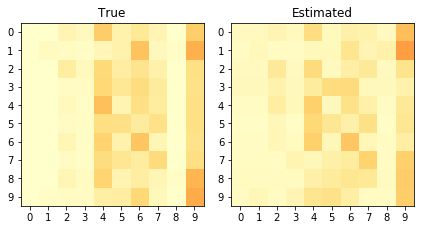

JS divergence: 0.0758	Norm Frobenius: 0.0533


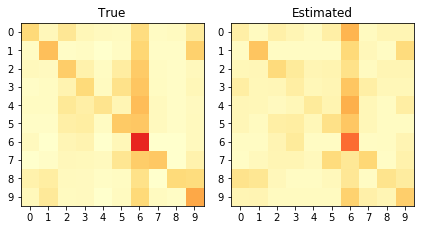

JS divergence: 0.0536	Norm Frobenius: 0.0536


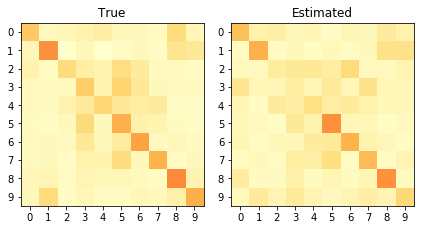

JS divergence: 0.0468	Norm Frobenius: 0.0530


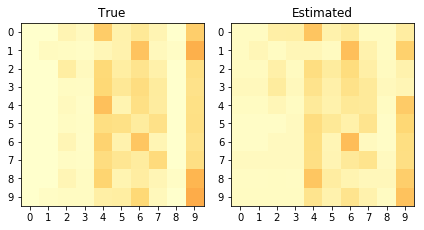

JS divergence: 0.0668	Norm Frobenius: 0.0486


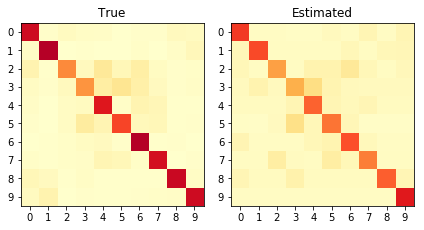

JS divergence: 0.0661	Norm Frobenius: 0.0679


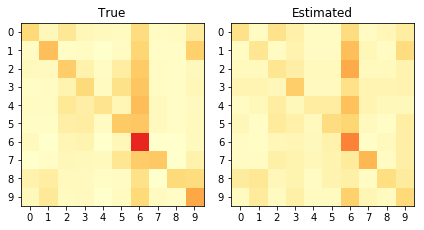

JS divergence: 0.0542	Norm Frobenius: 0.0564


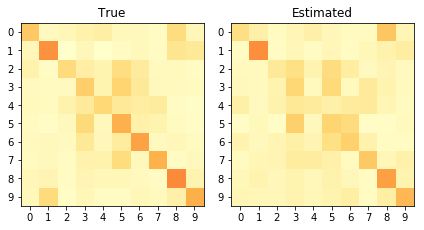

JS divergence: 0.0427	Norm Frobenius: 0.0508


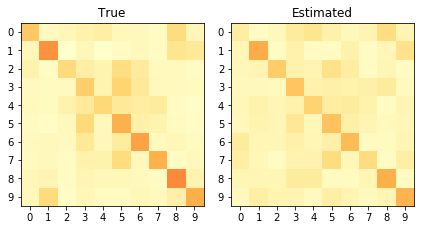

JS divergence: 0.0432	Norm Frobenius: 0.0510


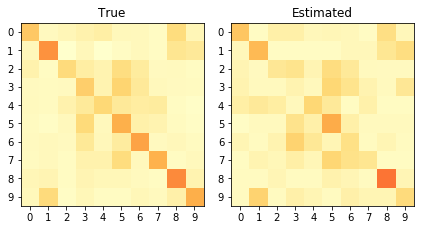

JS divergence: 0.0484	Norm Frobenius: 0.0583
Calculate confusion matrix on global version


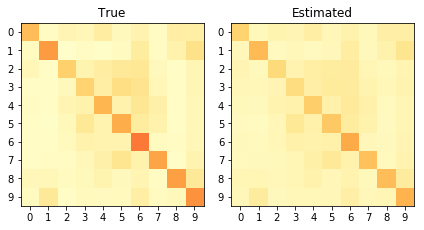

JS divergence: 0.0167	Norm Frobenius: 0.0341
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.78948,0.78948,0.058525,0.0574,0.05843,0.057274,0.034118,0.016687,0.150043,0.149812


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.411538,1.690319,0.411656,1.689794


Test
A result


,,Accuracy,F1 (micro)
0,All,0.7493,0.7493


In [44]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


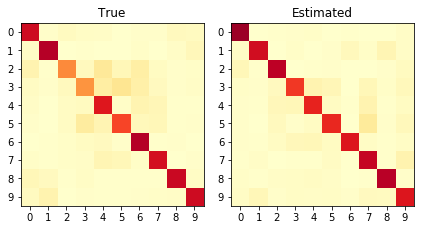

JS divergence: 0.0628	Norm Frobenius: 0.0588
Groups probabilities:  [1. 0. 0. 0.]


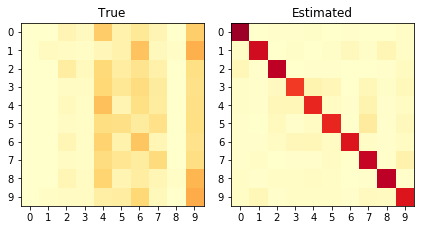

JS divergence: 0.4629	Norm Frobenius: 0.2372
Groups probabilities:  [0.98 0.   0.02 0.  ]


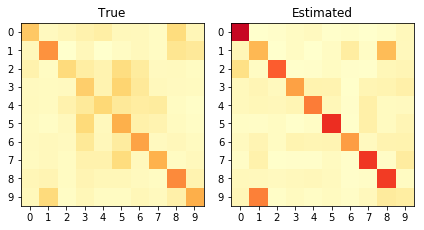

JS divergence: 0.1368	Norm Frobenius: 0.1161
Groups probabilities:  [0.   0.98 0.02 0.  ]


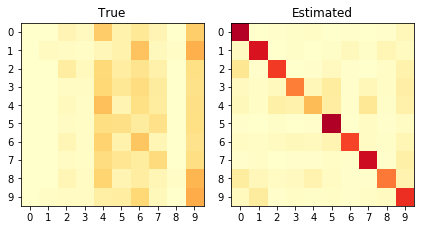

JS divergence: 0.4215	Norm Frobenius: 0.2106
Groups probabilities:  [0.02 0.   0.98 0.  ]


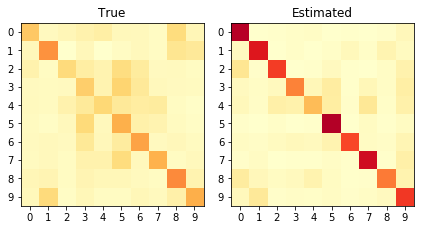

JS divergence: 0.1574	Norm Frobenius: 0.1296
Groups probabilities:  [0.   0.04 0.96 0.  ]


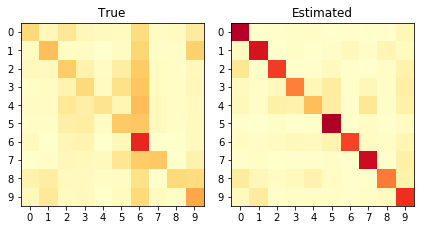

JS divergence: 0.2371	Norm Frobenius: 0.1603
Groups probabilities:  [0. 0. 1. 0.]


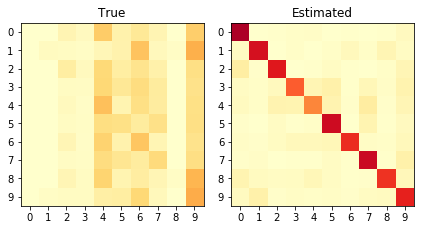

JS divergence: 0.4323	Norm Frobenius: 0.2204
Groups probabilities:  [0.45 0.   0.55 0.  ]


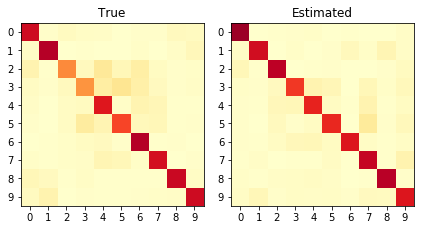

JS divergence: 0.0628	Norm Frobenius: 0.0588
Groups probabilities:  [1. 0. 0. 0.]


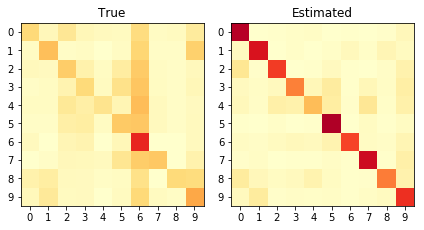

JS divergence: 0.2371	Norm Frobenius: 0.1603
Groups probabilities:  [0. 0. 1. 0.]


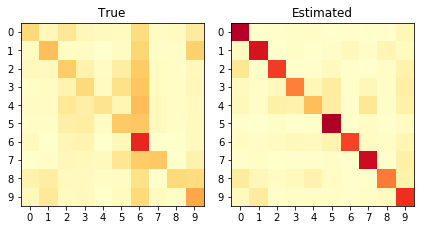

JS divergence: 0.2371	Norm Frobenius: 0.1603
Groups probabilities:  [0. 0. 1. 0.]


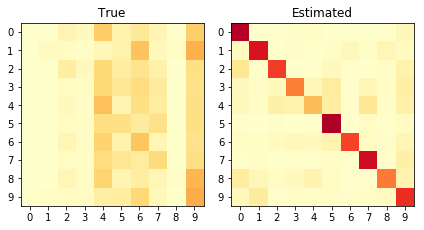

JS divergence: 0.4214	Norm Frobenius: 0.2104
Groups probabilities:  [0.01 0.   0.99 0.  ]


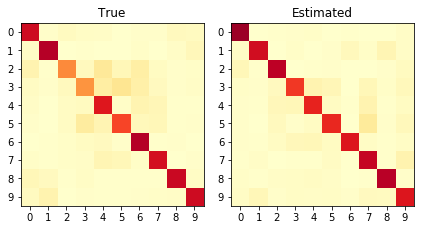

JS divergence: 0.0628	Norm Frobenius: 0.0588
Groups probabilities:  [1. 0. 0. 0.]


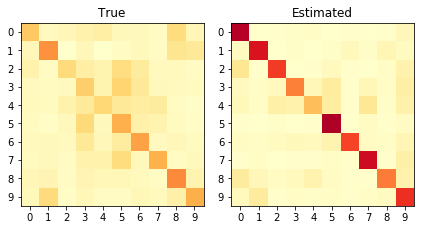

JS divergence: 0.1612	Norm Frobenius: 0.1315
Groups probabilities:  [0. 0. 1. 0.]


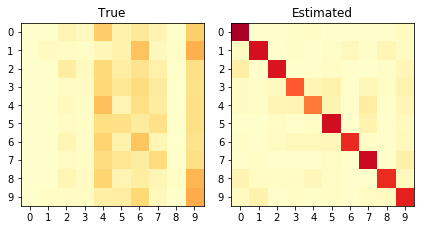

JS divergence: 0.4348	Norm Frobenius: 0.2221
Groups probabilities:  [0.51 0.   0.49 0.  ]


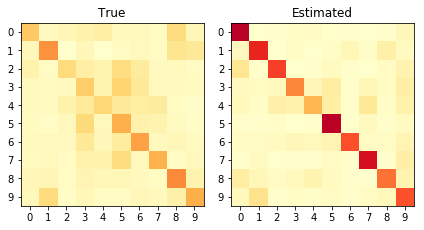

JS divergence: 0.1485	Norm Frobenius: 0.1248
Groups probabilities:  [0.   0.13 0.87 0.  ]
Calculate confusion matrix on global version


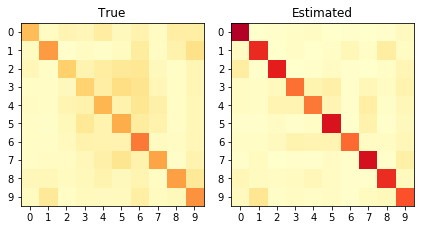

JS divergence: 0.1344	Norm Frobenius: 0.1188
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.85674,0.85674,0.134514,0.200746,0.134563,0.200899,0.118837,0.134378,0.43998,0.439916


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.388918,1.837354,0.389008,1.836978


Test


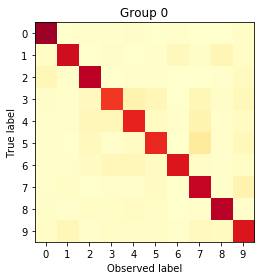

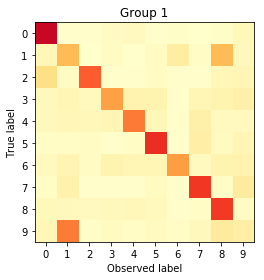

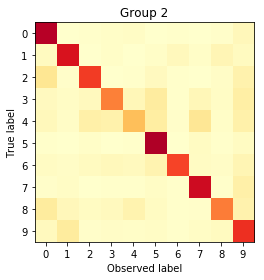

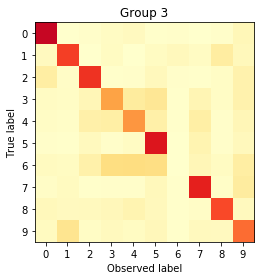

Inertia JS: 0.07430900638560366
Inertia NormF: 0.09473600089550017
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),Spammer,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.392719,785,0.835569,0.801933,0.843580,0.779926,0.074309,0.094736,0.7837,0.7837
1,1,0.147310,294,1.429072,0.534113,0.556588,0.482347,0.074309,0.094736,0.6987,0.6987
2,2,0.308772,617,1.141391,0.680296,0.723056,0.644774,0.074309,0.094736,0.7528,0.7528
3,3,0.151199,302,1.337219,0.579410,0.581760,0.532678,0.074309,0.094736,0.6832,0.6832


A result


,,Accuracy,F1 (micro)
0,All,0.7699,0.7699


In [48]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind2,'our1') 
aux = gMixture_Ind2.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind2.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual2 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind2.get_confusionM()
y_o_groups = gMixture_Ind2.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T$ = 10000, $T_{max}$ = 40 )

In [14]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.85384


*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


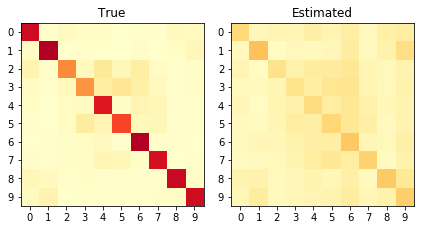

JS divergence: 0.2237	Norm Frobenius: 0.1684


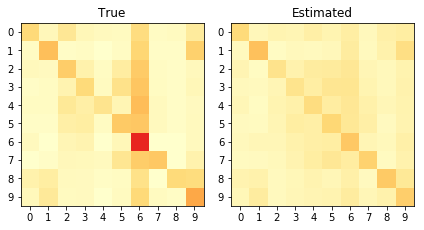

JS divergence: 0.0831	Norm Frobenius: 0.0737


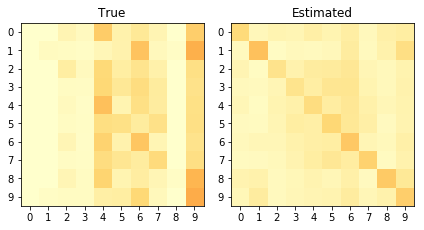

JS divergence: 0.1643	Norm Frobenius: 0.0901


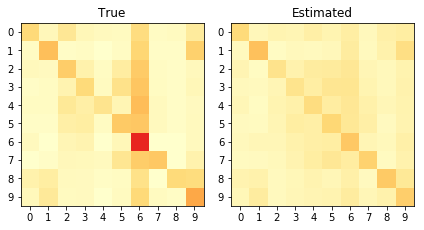

JS divergence: 0.0831	Norm Frobenius: 0.0737


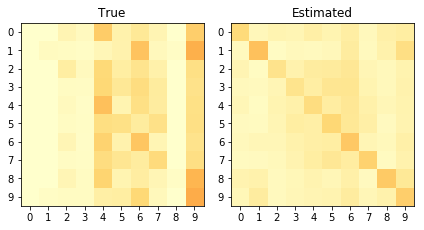

JS divergence: 0.1643	Norm Frobenius: 0.0901


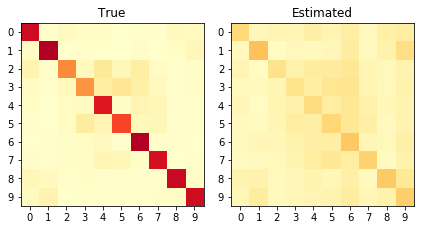

JS divergence: 0.2237	Norm Frobenius: 0.1684


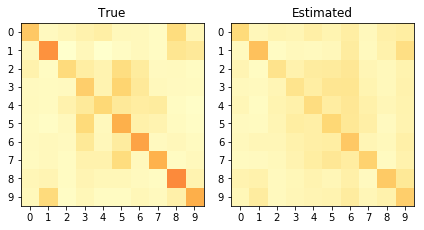

JS divergence: 0.0436	Norm Frobenius: 0.0557


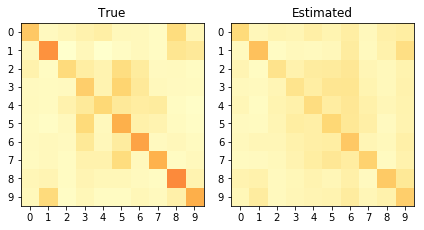

JS divergence: 0.0436	Norm Frobenius: 0.0557


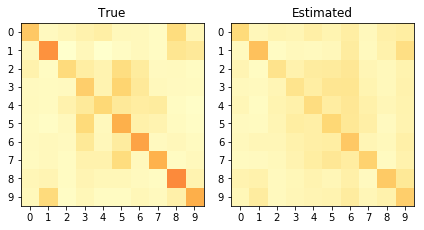

JS divergence: 0.0436	Norm Frobenius: 0.0557


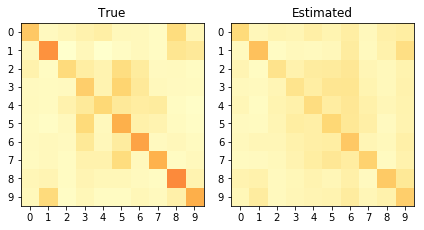

JS divergence: 0.0436	Norm Frobenius: 0.0557


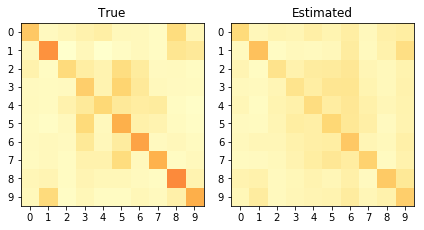

JS divergence: 0.0436	Norm Frobenius: 0.0557


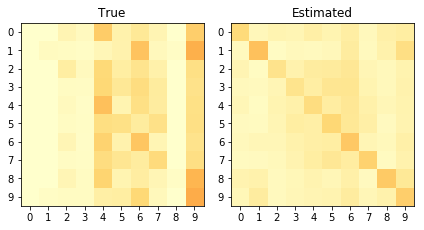

JS divergence: 0.1643	Norm Frobenius: 0.0901


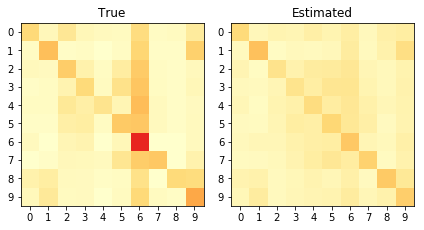

JS divergence: 0.0831	Norm Frobenius: 0.0737


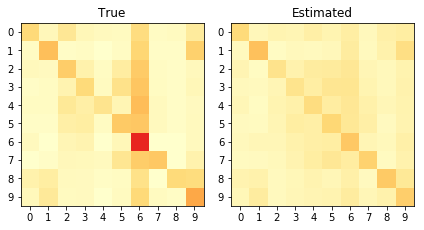

JS divergence: 0.0831	Norm Frobenius: 0.0737


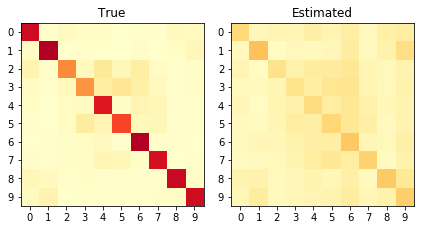

JS divergence: 0.2237	Norm Frobenius: 0.1684
Calculate confusion matrix on global version


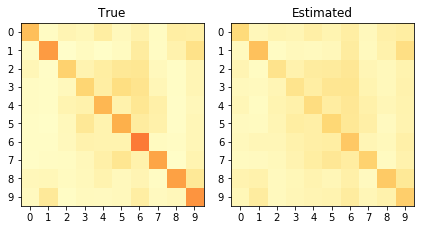

JS divergence: 0.0251	Norm Frobenius: 0.0498
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.47914,0.47914,0.08768,0.109795,0.087645,0.109736,0.049757,0.025103


Test
A result


,,Accuracy,F1 (micro)
0,All,0.4744,0.4744


In [15]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


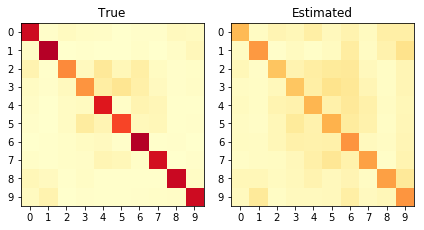

JS divergence: 0.1241	Norm Frobenius: 0.1227


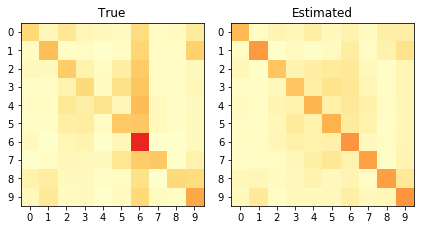

JS divergence: 0.0686	Norm Frobenius: 0.0725


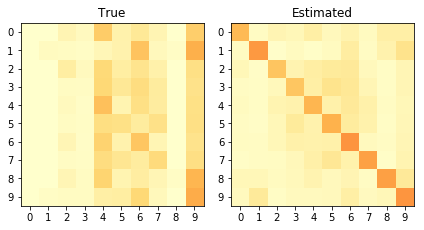

JS divergence: 0.1853	Norm Frobenius: 0.1137


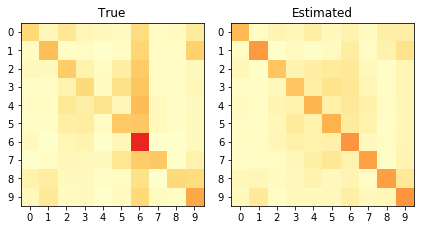

JS divergence: 0.0686	Norm Frobenius: 0.0725


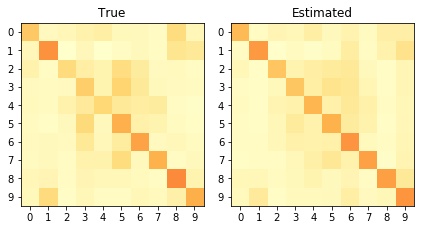

JS divergence: 0.0259	Norm Frobenius: 0.0400


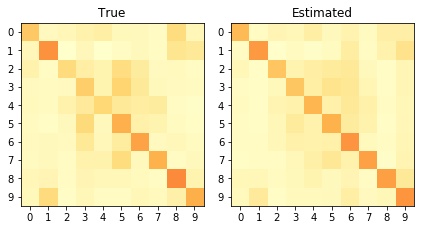

JS divergence: 0.0259	Norm Frobenius: 0.0400


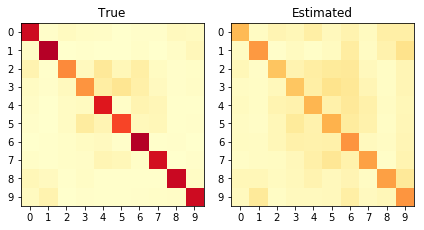

JS divergence: 0.1241	Norm Frobenius: 0.1227


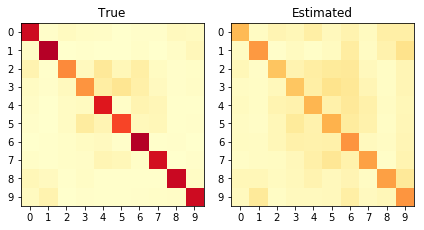

JS divergence: 0.1241	Norm Frobenius: 0.1227


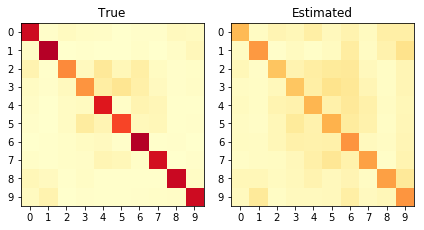

JS divergence: 0.1241	Norm Frobenius: 0.1227


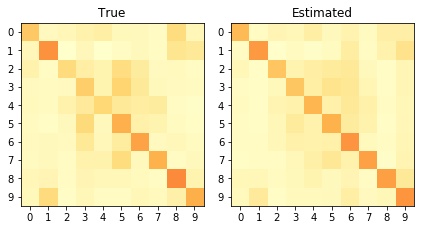

JS divergence: 0.0259	Norm Frobenius: 0.0400


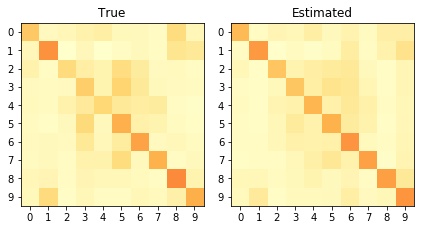

JS divergence: 0.0259	Norm Frobenius: 0.0400


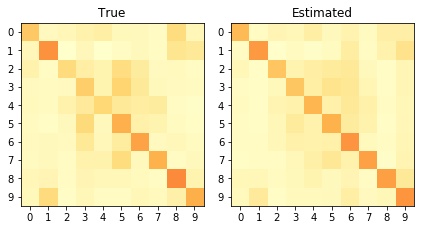

JS divergence: 0.0259	Norm Frobenius: 0.0400


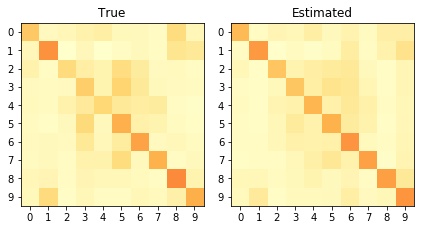

JS divergence: 0.0259	Norm Frobenius: 0.0400


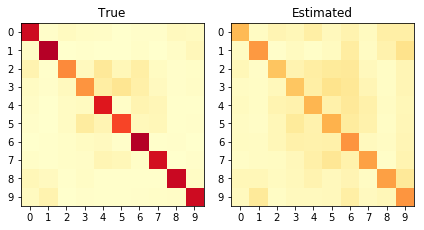

JS divergence: 0.1241	Norm Frobenius: 0.1227


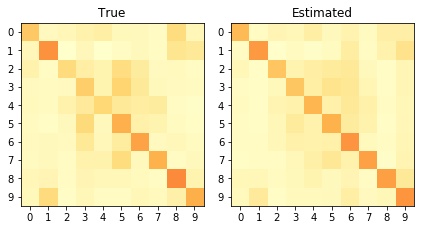

JS divergence: 0.0259	Norm Frobenius: 0.0400
Calculate confusion matrix on global version


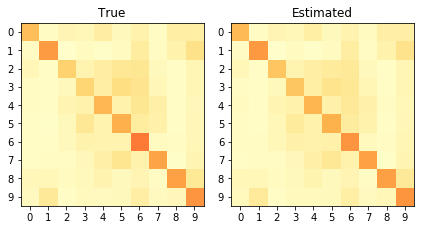

JS divergence: 0.0012	Norm Frobenius: 0.0117
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.78594,0.78594,0.076319,0.0844,0.076292,0.084362,0.011656,0.001184


Test
A result


,,Accuracy,F1 (micro)
0,All,0.7322,0.7322


In [17]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)
print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


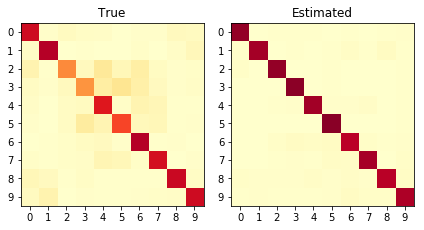

JS divergence: 0.0889	Norm Frobenius: 0.0887
Groups probabilities:  [1.00000000e+00 3.88159675e-43 4.68134958e-23 3.30993358e-11]


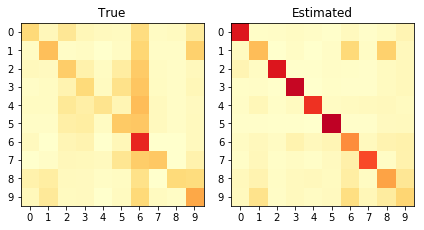

JS divergence: 0.2099	Norm Frobenius: 0.1559
Groups probabilities:  [1.42070803e-07 7.00649232e-45 1.22288056e-03 9.98776972e-01]


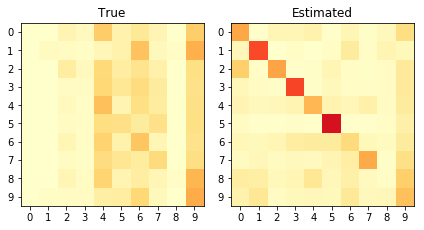

JS divergence: 0.2829	Norm Frobenius: 0.1501
Groups probabilities:  [1.21943124e-14 2.83853862e-31 9.99989271e-01 1.07737742e-05]


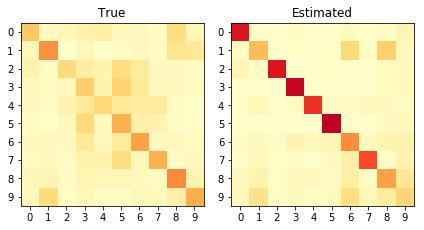

JS divergence: 0.1641	Norm Frobenius: 0.1370
Groups probabilities:  [1.99763349e-07 5.10153118e-12 4.15108348e-09 9.99999762e-01]


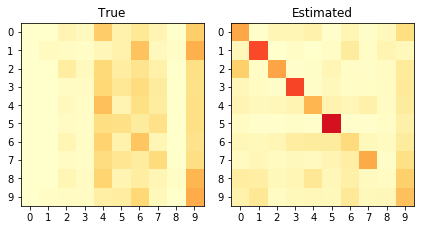

JS divergence: 0.2830	Norm Frobenius: 0.1501
Groups probabilities:  [1.74704698e-17 1.34820627e-18 9.98819888e-01 1.18012808e-03]


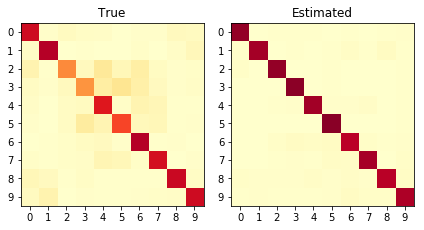

JS divergence: 0.0889	Norm Frobenius: 0.0887
Groups probabilities:  [1.00000000e+00 0.00000000e+00 6.16579153e-28 1.22525557e-12]


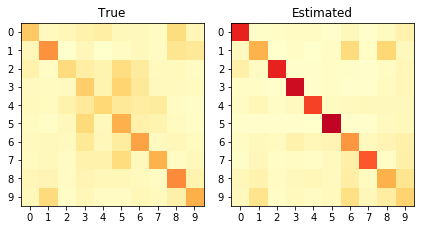

JS divergence: 0.1515	Norm Frobenius: 0.1297
Groups probabilities:  [9.43261000e-07 9.51888241e-24 1.19135536e-01 8.80863547e-01]


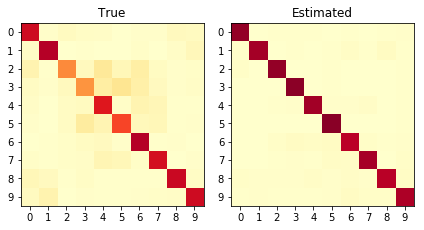

JS divergence: 0.0889	Norm Frobenius: 0.0887
Groups probabilities:  [9.99998569e-01 1.08174807e-36 1.11459776e-20 1.47185494e-06]


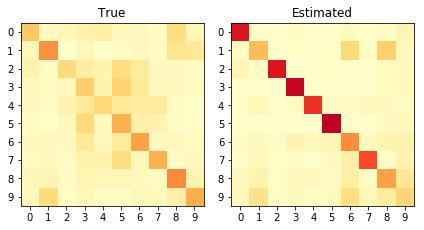

JS divergence: 0.1641	Norm Frobenius: 0.1370
Groups probabilities:  [4.95577327e-14 2.21981388e-19 2.78100856e-06 9.99997258e-01]


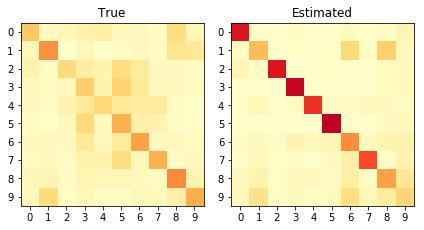

JS divergence: 0.1641	Norm Frobenius: 0.1370
Groups probabilities:  [3.40536950e-08 2.44563325e-05 5.56950090e-06 9.99969959e-01]


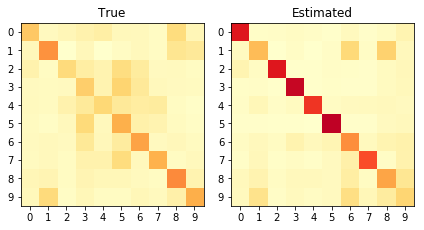

JS divergence: 0.1621	Norm Frobenius: 0.1359
Groups probabilities:  [1.55002816e-10 1.61608716e-06 1.69955064e-02 9.83002841e-01]


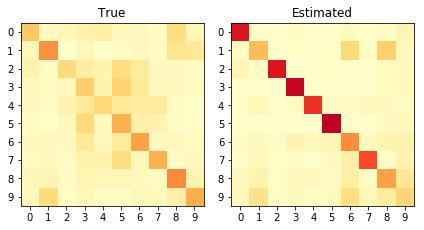

JS divergence: 0.1641	Norm Frobenius: 0.1370
Groups probabilities:  [1.10622739e-06 9.54635897e-22 9.21066672e-08 9.99998808e-01]


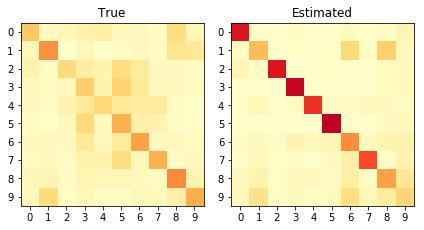

JS divergence: 0.1641	Norm Frobenius: 0.1370
Groups probabilities:  [4.13865820e-07 1.49668863e-22 1.26486086e-07 9.99999404e-01]


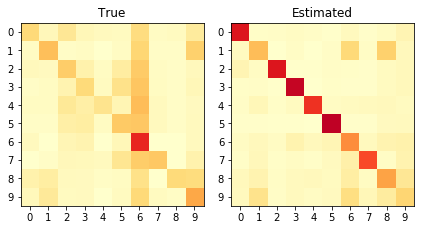

JS divergence: 0.2101	Norm Frobenius: 0.1560
Groups probabilities:  [3.91419871e-06 0.00000000e+00 1.40579814e-05 9.99981999e-01]


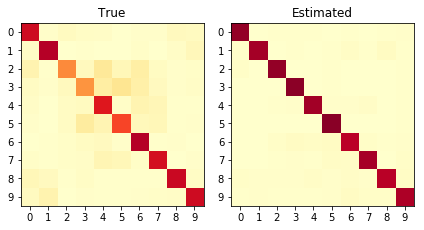

JS divergence: 0.0889	Norm Frobenius: 0.0887
Groups probabilities:  [1.00000000e+00 0.00000000e+00 1.29416457e-16 9.46693612e-10]
Calculate confusion matrix on global version


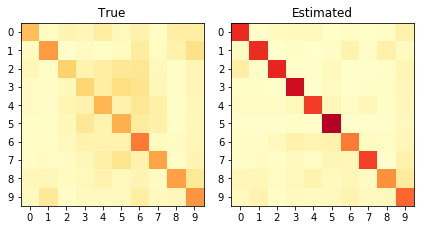

JS divergence: 0.1175	Norm Frobenius: 0.1199
A result


,,Accuracy,F1 (micro),(R) NormF mean,(R) JS mean,(G) NormF,(G) JS
0,All,0.81246,0.81246,0.133152,0.181475,0.11986,0.11753


Test


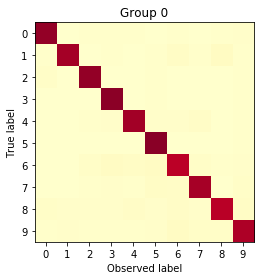

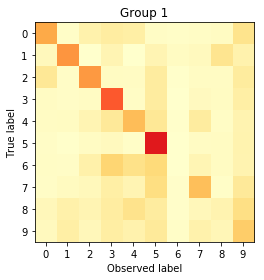

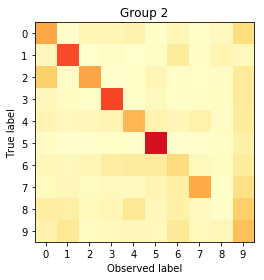

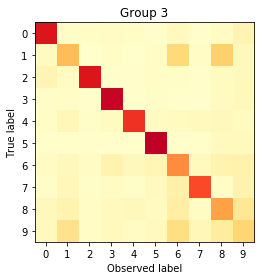

Inertia JS: 0.17408410060350052
Inertia NormF: 0.13217644790808358
A result


,Groups,Prob,Entropy,Diag mean,Isim (JS),Spammer,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.464987,0.381569,0.930425,0.948183,0.922695,0.174084,0.132176,0.7600,0.7600
1,1,0.142375,1.730429,0.372778,0.328216,0.303087,0.174084,0.132176,0.4368,0.4368
2,2,0.254897,1.684488,0.424066,0.410842,0.360074,0.174084,0.132176,0.6259,0.6259
3,3,0.137740,1.307383,0.609777,0.643643,0.566419,0.174084,0.132176,0.7023,0.7023


A result


,,Accuracy,F1 (micro)
0,All,0.733,0.733


In [31]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
#aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
#predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
#prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
#y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
print("Test")
c_M = gMixture_Global.get_confusionM()
#y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 + bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

#### 7) configuration: Manny annot v1 + soft ($T$ = 2000, $T_{max}$ = 20 )

evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### Test annotations CIFAR
---
try to find groups...

In [5]:
from scipy.io import loadmat
from code.utils import *
from code.representation import *
from code.evaluation import Evaluation_metrics
from code.baseline import *


#change sets
aux1 = Xstd_train.copy()
aux2 = Z_train.copy()
Xstd_train = Xstd_test.copy()
Z_train = Z_test.copy()
Xstd_test = aux1[:10000]
Z_test = aux2[:10000]

N = Xstd_train.shape[0]

In [6]:
folder = "./" #"../New_CIFAR_test/"

aux = loadmat(folder+"CIFAR10_HumanRecogData.mat")
aux = aux["expData"][0][0][0]
T = 60+1 #one GT to augment data
y_obs = np.ones((N,T),dtype='int16')*-1
for annotation in aux:
    ann_id = annotation[0]-1
    cifar_indx = annotation[1]-1
    ann = annotation[2]-1
    y_obs[cifar_indx,ann_id] = ann
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
  
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_soft = label_I.mv_labels('probas')
print("ACC MV on train:",np.mean(mv_soft.argmax(axis=1)==Z_train))
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Representation for MV in 1.084394 sec
Estimation MV in 0.027947 sec
ACC MV on train: 0.9757
Normalized entropy (0-1) of repeats annotations: 0.05247443779676492


In [7]:
#agregar nuevas anotaciones GT... aumentar X
#aux1[10000:].shape
Xstd_train = np.concatenate([Xstd_train,aux1[10000:]],axis=0)
Z_train = np.concatenate([Z_train,aux2[10000:]],axis=0)
y_obs_aux = np.ones((aux2[10000:].shape[0],T),dtype='int16')*-1
y_obs_aux[:,-1] = aux2[10000:]
y_obs = np.concatenate([y_obs,y_obs_aux],axis=0)
y_obs.shape

(50000, 61)

In [7]:
#generate conf matrix...
confe_matrix = np.zeros((T,K,K),dtype=DTYPE_OP)
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix[t,Z_train[i],y_obs[i,t]] +=1
    mask_nan = confe_matrix[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix[t,:,:][~mask_nan],axis=0)
    for value in np.arange(K)[mask_nan]:
        confe_matrix[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix[t,:,:] = confe_matrix[t,:,:]/confe_matrix[t,:,:].sum(axis=-1,keepdims=True) #normalize
    
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


shape: (10000, 61, 10)


In [9]:
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_soft = label_I.mv_labels('probas')
print("ACC MV on train:",np.mean(mv_soft.argmax(axis=1)==Z_train))

ACC MV on train: 0.99514


In [10]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs,"repeat")

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 5 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
shape: (50000, 10)


In [11]:
M_seted = 4 #to find anything that is...

In [76]:
imp = 0.01 #importance/relevance of prior
imp*(r_obs.sum(axis=-1).sum(axis=-1)/M_seted) #to get a uniform groups...


250.0

In [77]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default cnn")
#gMixture_Global.define_model("simple cnn",32,2,double=True,BatchN=True,drop=0.25)

gMixture_Global.define_priors("laplace")
gMixture_Global.define_priors(np.tile(25000*imp,gMixture_Global.M)) #revisra sin esto queda con prior de 1...

gMixture_Global.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=30,tolerance=TOL
                                   ,cluster=True) #more?

Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.116293 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65119505 0.51234937 0.36077574 0.9283851 ]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/30
M step: done,  E step: done //  (in 13.63 sec)	logL: -208263.245	
Iter 2/30
M step: done,  E step: done //  (in 11.59 sec)	logL: -99951.044	Tol1: 0.52007	Tol2: 0.94159	Tol3: 0.61447	
Iter 3/30
M step: done,  E step: done //  (in 11.59 sec)	logL: -86466.027	Tol1: 0.13492	Tol2: 0.35394	Tol3: 0.05798	
Iter 4/30
M step: done,  E step: done //  (in 11.52 sec)	logL: -82021.620	Tol1: 0.05140	Tol2: 0.26194	Tol3: 0.09159	
Iter 5/30
M step: done,  E step: done //  (in 11.64 sec)	logL: -81635.350	Tol1: 0.00471	Tol2: 0.30479	Tol3: 0.09750	
Iter 6/30
M step: done,  E step: done //  (in 11.59 sec)	logL: -62142.304	Tol1: 0.23878	Tol2: 0.37286	Tol3: 0.11061	
Iter 7/30
M step: done,  E step: done //  

In [80]:
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

*** Ours Global multiples runs***
Train


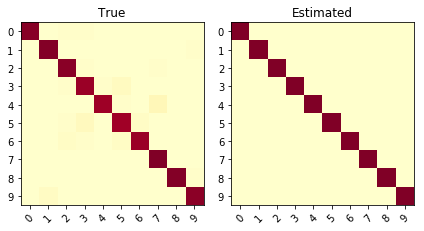

JS divergence: 0.0148	Norm Frobenius: 0.0153
Groups probabilities:  [1.00000000e+00 4.84365459e-33 2.38423168e-31 3.70810864e-34]


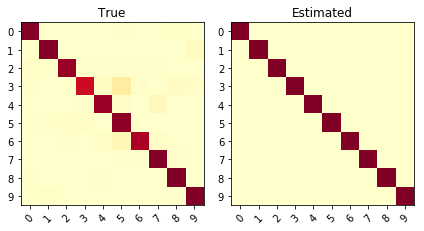

JS divergence: 0.0296	Norm Frobenius: 0.0296
Groups probabilities:  [1.00000000e+00 1.43688803e-16 4.76734707e-16 3.44149496e-20]


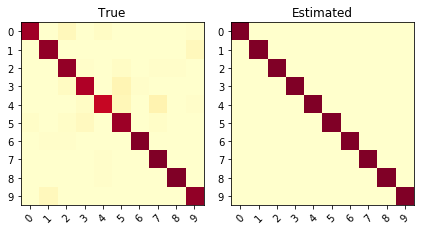

JS divergence: 0.0284	Norm Frobenius: 0.0279
Groups probabilities:  [1.00000000e+00 6.87939960e-38 4.54822433e-36 1.04797871e-38]


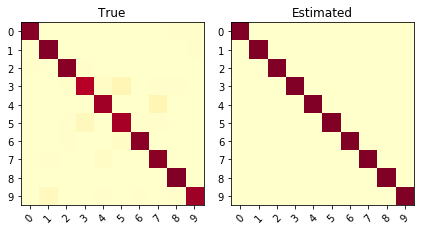

JS divergence: 0.0198	Norm Frobenius: 0.0207
Groups probabilities:  [1.00000000e+00 1.09225664e-29 6.10223921e-28 1.48712232e-30]


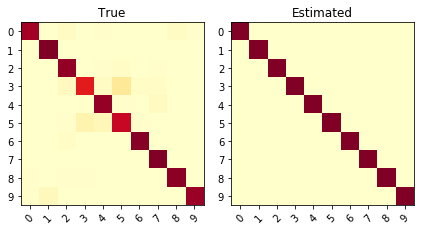

JS divergence: 0.0333	Norm Frobenius: 0.0374
Groups probabilities:  [1.00000000e+00 4.97514273e-30 1.23251697e-27 2.47461911e-29]


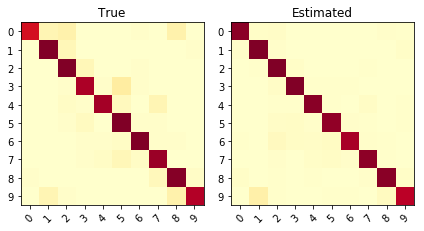

JS divergence: 0.0342	Norm Frobenius: 0.0291
Groups probabilities:  [5.88631478e-29 7.89367873e-03 9.92078722e-01 2.75199855e-05]


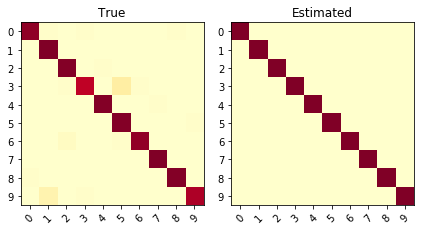

JS divergence: 0.0164	Norm Frobenius: 0.0223
Groups probabilities:  [1.00000000e+00 1.79361669e-34 7.00037919e-31 1.12561046e-35]


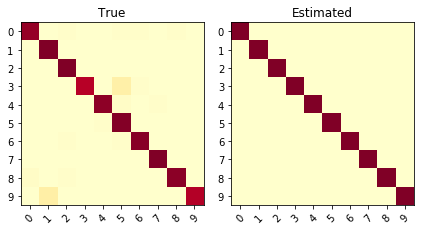

JS divergence: 0.0167	Norm Frobenius: 0.0221
Groups probabilities:  [1.00000000e+00 2.64046796e-35 2.96889977e-31 3.57419375e-36]


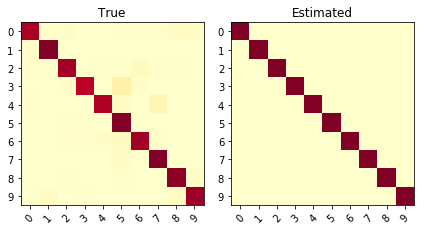

JS divergence: 0.0311	Norm Frobenius: 0.0287
Groups probabilities:  [9.98677433e-01 1.11919755e-04 1.21061713e-03 5.38349454e-09]


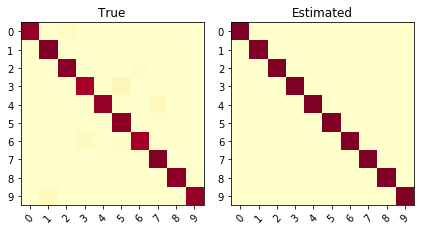

JS divergence: 0.0178	Norm Frobenius: 0.0172
Groups probabilities:  [1.00000000e+00 1.18008842e-28 4.78347843e-27 8.70390325e-32]


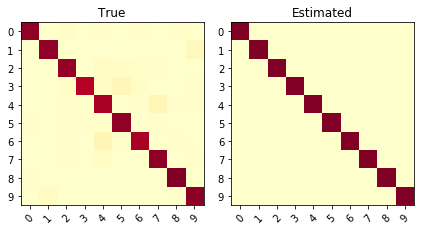

JS divergence: 0.0278	Norm Frobenius: 0.0250
Groups probabilities:  [1.00000000e+00 7.91923978e-20 1.45928040e-18 5.12872427e-23]


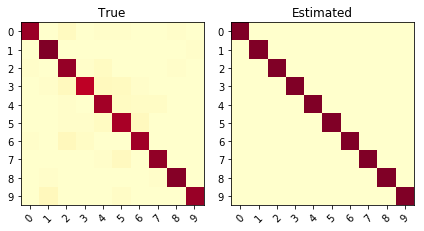

JS divergence: 0.0298	Norm Frobenius: 0.0260
Groups probabilities:  [1.00000000e+00 4.26487991e-20 1.13737345e-18 1.82772054e-22]


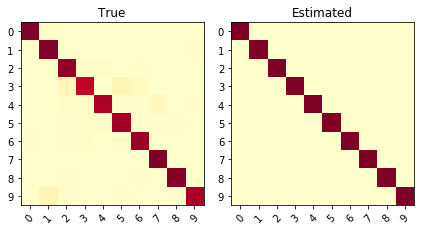

JS divergence: 0.0253	Norm Frobenius: 0.0253
Groups probabilities:  [1.00000000e+00 4.37623780e-21 4.85393616e-19 5.28571706e-23]


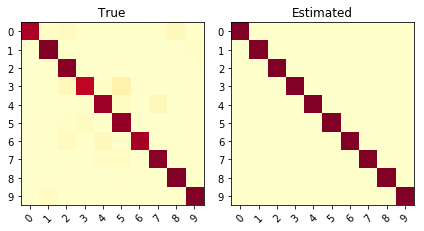

JS divergence: 0.0313	Norm Frobenius: 0.0288
Groups probabilities:  [1.00000000e+00 4.64958869e-20 1.34671763e-19 2.46503540e-23]


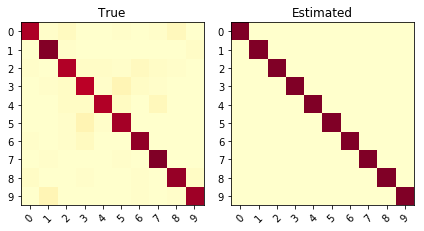

JS divergence: 0.0384	Norm Frobenius: 0.0325
Groups probabilities:  [1.00000000e+00 6.88718735e-11 6.93546442e-10 4.74420763e-12]
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global     0.94316       0.94316     0.0320965  0.0399045       0.136154    0.314288    0.0315832       0.04406
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  

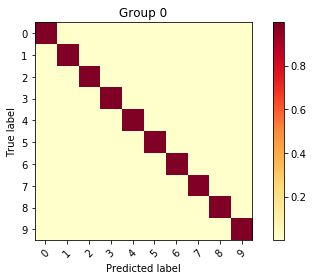

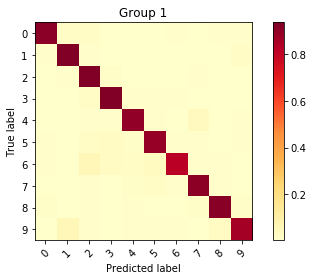

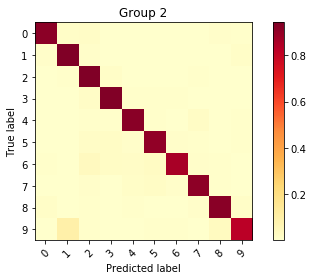

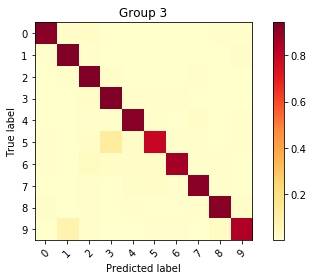

Inertia: 0.021954019650027735
A result
 ====  ========  =========  ======  =========  ===========  ==========  =============  =========  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean     KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  ==========  =============  =========  ==========  ============
   0         0  0.886699       54  0.0283678     0.996734  0.00326404       0.997649   0.996371      0.8406        0.8406
   1         1  0.0365357       2  0.503887      0.902728  0.103061         0.926894   0.89192       0.8402        0.8402
   2         2  0.0384692       2  0.477935      0.908018  0.0972566        0.930971   0.897798      0.8406        0.8406
   3         3  0.0382964       2  0.498323      0.900207  0.106503         0.924624   0.889119      0.8398        0.8398
====  ========  =========  ======  =========  ===========  ==========  =============  =========  =========

In [82]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)
#results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

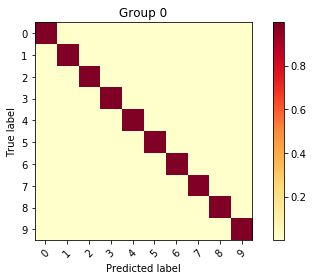

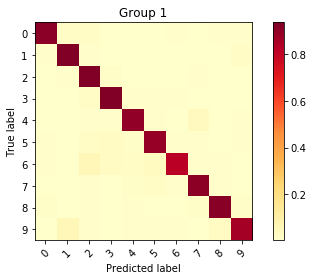

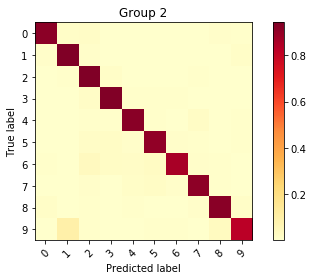

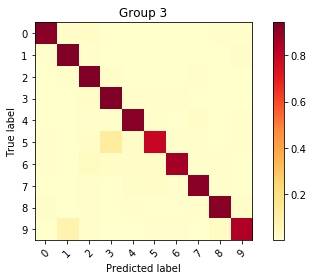

Inertia: 0.021954019650027735
A result
 ====  ========  =========  =========  ===========  ==========  =============  =========
  ..    Groups       Prob    Entropy    Diag Mean     KL to I    I sim %(JS)    Spammer
====  ========  =========  =========  ===========  ==========  =============  =========
   0         0  0.886699   0.0283678     0.996734  0.00326404       0.997649   0.996371
   1         1  0.0365357  0.503887      0.902728  0.103061         0.926894   0.89192
   2         2  0.0384692  0.477935      0.908018  0.0972566        0.930971   0.897798
   3         3  0.0382964  0.498323      0.900207  0.106503         0.924624   0.889119
====  ========  =========  =========  ===========  ==========  =============  =========


In [83]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
c_M = gMixture_Global.get_confusionM()

results = evaluate.calculate_metrics(conf_pred=c_M)